# 80 Cereals

## Introduction

If there was to be a storytelling in this project, this is the section, but it's quite a small project, without much story (for the project's scope) to tell

### Objectives

- Use regression to predict the rating
- Classify per rating (bad, decent, good), or even by stars (1 - 5 or 1 - 10)
- Create a mapping decoder to know what details each thing belongs to

### Challenges

- A small dataset, like really small, 80 samples, but only 77 available at first

### References

The origina Kaggle Dataset:

- https://www.kaggle.com/datasets/crawford/80-cereals

### Attributes

- name: Name of cereal
- mfr: Manufacturer of cereal
 - A = American Home Food Products;
 - G = General Mills
 - K = Kelloggs
 - N = Nabisco
 - P = Post
 - Q = Quaker Oats
 - R = Ralston Purina 
- type:
 - cold
 - hot 
- calories: calories per serving
- protein: grams of protein
- fat: grams of fat
- sodium: milligrams of sodium
- fiber: grams of dietary fiber
- carbo: grams of complex carbohydrates
- sugars: grams of sugars
- potass: milligrams of potassium
- vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
- shelf: display shelf (1, 2, or 3, counting from the floor)
- weight: weight in ounces of one serving
- cups: number of cups in one serving
- rating: a rating of the cereals (Possibly from Consumer Reports?)

## Initialization

In [1]:
RANDOM_SEED = 42 #@param {type: 'integer'}
DEVELOPMENT_ENVIRONMENT = True #@param {type:'boolean'}
if DEVELOPMENT_ENVIRONMENT:
  RANDOM_SEED = 42

Let's detect if we're working from Google Colab or simply from a local machine

In [2]:
try:
  import google.colab
  IS_NOTEBOOK_IN_GOOGLE_COLAB = True
except:
  IS_NOTEBOOK_IN_GOOGLE_COLAB = False
IS_NOTEBOOK_IN_GOOGLE_COLAB

True

### Imports

In [928]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib
matplotlib.use('GTK3Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from math import ceil

### Mount Google Drive

We just need temporary access for our Kaggle credentials

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configure Kaggle

Instead of referencing to some local data, or cloud stored on my personal drive files, let's just get the data directly from the source, better ethically and more user-friendly. The detailed, step by step guide is being followed from:

- https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

For that, we'll first install Kaggle's Python library

In [5]:
%pip install kaggle -q

This'll only execute if we're working from Google Colab. We should now move our kaggle.json to the proper location, which is root.

In [6]:
%cp "/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json" "kaggle.json"

Move our `kaggle.json` to the working directory

In [7]:
%mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

We can now download our dataset

In [8]:
!kaggle datasets download "crawford/80-cereals"

  0% 0.00/2.24k [00:00<?, ?B/s]
100% 2.24k/2.24k [00:00<00:00, 2.32MB/s]


A simply unzip should suffice

In [9]:
!unzip "80-cereals.zip"

Archive:  80-cereals.zip
  inflating: cereal.csv              


Aaaaaaand we're good to go

### Load the dataset

In [10]:
TARGET_VARIABLE = 'rating' #@param {type: 'string'}
# TARGET_VARIABLE = 'fiber' #@param {type: 'string'}

In [536]:
dataframe = pd.read_csv('./cereal.csv')

A quick check that' everything's fine

In [12]:
dataframe.head(5)

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


Let's see how many values we'll be working with, since we know they won't be that many

In [537]:
len(dataframe)

77

### Dictionaries

Some of the values, more precisely, the manufacturer is anonimized, we'll need some dictionaries to understand it's values

#### Manufacturer

In [13]:
manufacturer_dict = {
  'A': 'American Home Food Products;',
  'G': 'General Mills',
  'K': 'Kelloggs',
  'N': 'Nabisco',
  'P': 'Post',
  'Q': 'Quaker Oats',
  'R': 'Ralston Purina ',
}

In [14]:
# dataframe['mfr'] = dataframe['mfr'].apply(lambda x: manufacturer_dict[x])

#### Type

In [15]:
type_dict = {
  'C': 'Cold',
  'H': 'Hot',
}

In [16]:
# dataframe['type'] = dataframe['type'].apply(lambda x: type_dict[x])

## Exploratory Data Analysis (EDA)

Let's do a simple exploratory data analysis to further understand the data that we'll be working with. We should be able to grasp an idea of what's the dataset like and it's facets.

Amount of values/rows

In [17]:
len(dataframe)

77

With a small dataset, this is, as for the base dataframe, the total amount of data the model will have to compute

In [538]:
len(dataframe) * len(dataframe.columns)

1232

We can also extract something obvious from here, we will never conclude with a "good" result, it may, of course, lead to a higher score but not a good enough understanding, since it will overfit itself.

### Helpers

Some utility functions for our plotting, this will be used and will help plotting all over the notebook, and, hopefully, they will simplify the plotting process

#### Subplotting

Subplotting is an easy way to visualize multiple plots all at once, for the purposes of this project, it will, mostly, be used to plot different columns of the same dataframe, with exactly the same visualization, which is what our function helps us do.

But first some basic subplot configuration

In [924]:
default_subplot_adjustment = {
  # 'left': 0.1,
  'left': None,
  # 'bottom': 0.1,
  'bottom': None,
  # 'right': 0.9,
  'right': None,
  # 'top': 0.9,
  'top': None,
  'wspace': 0.4,
  'hspace': 0.4,
}

Then, the function, it currently only supports multidimensional subplotting.

But vector subploting should also be available

In [939]:
def subplots_grid_visualizer(
  dataframe: pd.DataFrame,
  columns: List[str],
  visualizer: callable,
  n_cols: int = 5,
  subplot_col_width: float = 7.5,
  subplot_col_height: float = 5,
  color_palette = sns.color_palette('Paired'),
  subplots_adjustment: dict = default_subplot_adjustment,
  title: str = None,
  figsize: Tuple[float, float] = None
) -> None:
  df_subplot = dataframe.copy(deep=True)
  # subplots grid configuration
  total_columns = len(columns)
  cols_to_display = n_cols
  rows_to_display = ceil(total_columns / cols_to_display)

  # subplots sizing
  if not figsize:
    figsize = (
      cols_to_display * subplot_col_width,
      rows_to_display * subplot_col_height
    )

  # subplots initialization
  fig, axes = plt.subplots(rows_to_display, cols_to_display, figsize=figsize)
  if title:
    plt.suptitle(title, fontsize='xx-large')

  # set the spacing between subplots
  plt.subplots_adjust(**subplots_adjustment)

  # the actual plotting
  for index, col in enumerate(columns):
    ax = axes[
      int(index / cols_to_display),
      int(index % cols_to_display)
    ]
    visualizer(df_subplot, index, col, ax, color_palette)

### Missing values

Machine and Deep Learning Models only work without missing values. A missing value is an attribute that's a `NaN` in a row, basically, a null value

We can see some non-numeric data types which we'll have to transform, but 0% of missing values, which is great.

In [18]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      77 non-null     object 
 1   mfr       77 non-null     object 
 2   type      77 non-null     object 
 3   calories  77 non-null     int64  
 4   protein   77 non-null     int64  
 5   fat       77 non-null     int64  
 6   sodium    77 non-null     int64  
 7   fiber     77 non-null     float64
 8   carbo     77 non-null     float64
 9   sugars    77 non-null     int64  
 10  potass    77 non-null     int64  
 11  vitamins  77 non-null     int64  
 12  shelf     77 non-null     int64  
 13  weight    77 non-null     float64
 14  cups      77 non-null     float64
 15  rating    77 non-null     float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.8+ KB


### Abnormal values

Something that may be weird. Let's check for some abnormal values, there shoudln't be something too weird.

For example, I'm not food nutritionist, but it doesn't make much sense to me to have a nutritional attribute being negative.

In [19]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
calories,77.0,106.883117,19.484119,50.000000,100.000000,110.000000,110.000000,160.000000
protein,77.0,2.545455,1.094790,1.000000,2.000000,3.000000,3.000000,6.000000
fat,77.0,1.012987,1.006473,0.000000,0.000000,1.000000,2.000000,5.000000
sodium,77.0,159.675325,83.832295,0.000000,130.000000,180.000000,210.000000,320.000000
fiber,77.0,2.151948,2.383364,0.000000,1.000000,2.000000,3.000000,14.000000
carbo,77.0,14.597403,4.278956,-1.000000,12.000000,14.000000,17.000000,23.000000
sugars,77.0,6.922078,4.444885,-1.000000,3.000000,7.000000,11.000000,15.000000
potass,77.0,96.077922,71.286813,-1.000000,40.000000,90.000000,120.000000,330.000000
vitamins,77.0,28.246753,22.342523,0.000000,25.000000,25.000000,25.000000,100.000000
shelf,77.0,2.207792,0.832524,1.000000,1.000000,2.000000,3.000000,3.000000


### Data types

Let's focus on non-numeric values for the moment being, we'll handle the numeric columns when preprocessing the values

In [20]:
dataframe.select_dtypes(exclude=np.number).dtypes

name    object
mfr     object
type    object
dtype: object

### Data distribution

No matter the size of a dataset, distribution is always important, if something, on smaller datasets, it takes an even bigger role

#### Rating

We can't just talk about distribution without seeing how our target variable is distributed

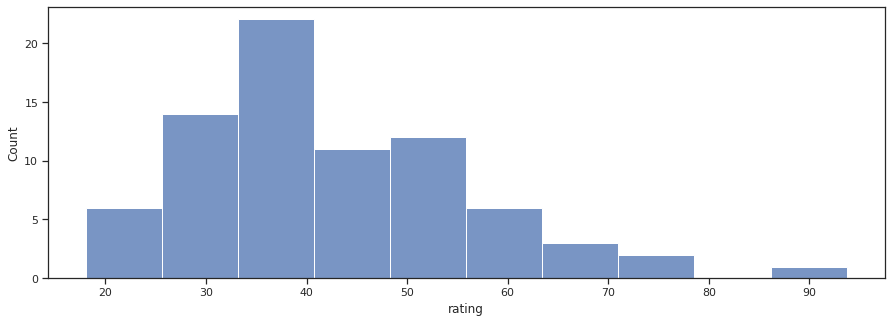

In [926]:
plt.figure(figsize=(15, 5))
_ = sns.histplot(data=dataframe, x=TARGET_VARIABLE)

#### Type

The cereal type, cold or hot

In [21]:
dataframe['type'].unique()

array(['C', 'H'], dtype=object)

As we can clearly see, there's barely any hot type of cereal, given the small dataset, we can not consider having the type as a factor, it'd be best to delete it

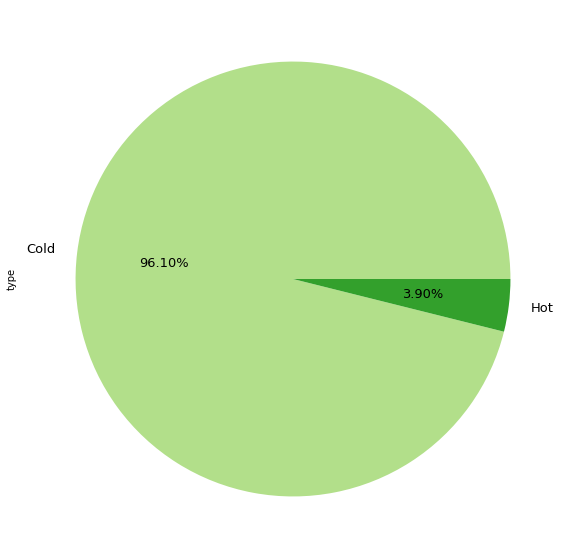

In [22]:
plt.figure(figsize=(10, 10))
_ = dataframe['type'].apply(
  lambda x: type_dict[x],
).value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired')[2:],
)

#### MFR

MFR, The manufacturer of those cereals

In [23]:
dataframe['mfr'].unique()

array(['N', 'Q', 'K', 'R', 'G', 'P', 'A'], dtype=object)

Let's see it's distribution this time around. It actually has more distribution, even though one of the manufacturers is clearly outnumbered, there's still varieaty enough so that we can consider this attribute a possibility

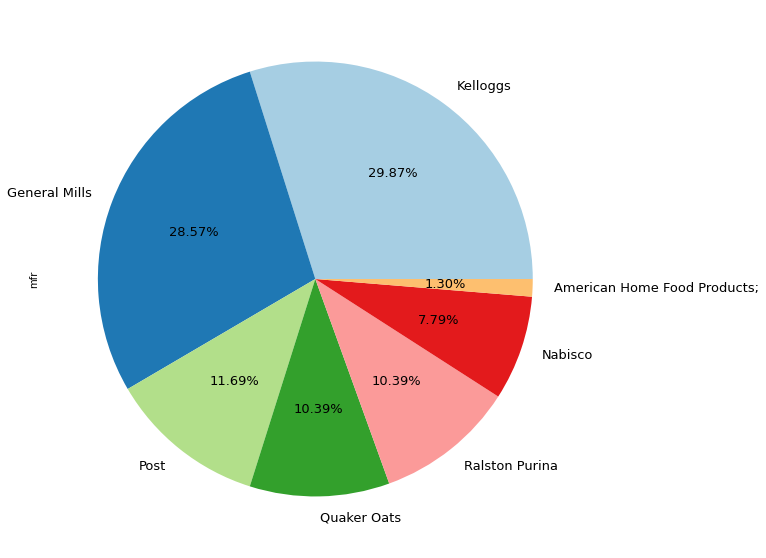

In [24]:
plt.figure(figsize=(10, 10))
_ = dataframe['mfr'].apply(
  lambda x: manufacturer_dict[x],
).value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired'),
)

American Home Food Products has the lowest percentage of cereals, only one.
It will be a biased value, so it's better to just remove the row itself

In [539]:
dataframe[dataframe['mfr'] == 'A']

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
43,Maypo,A,H,100,4,1,0,0.0,16.0,3,95,25,2,1.0,1.0,54.850917


#### Overall with histograms

Being able to, at a glance, see all of the data distribution is really important, as it can help us understand/avoid future problems we may encounter

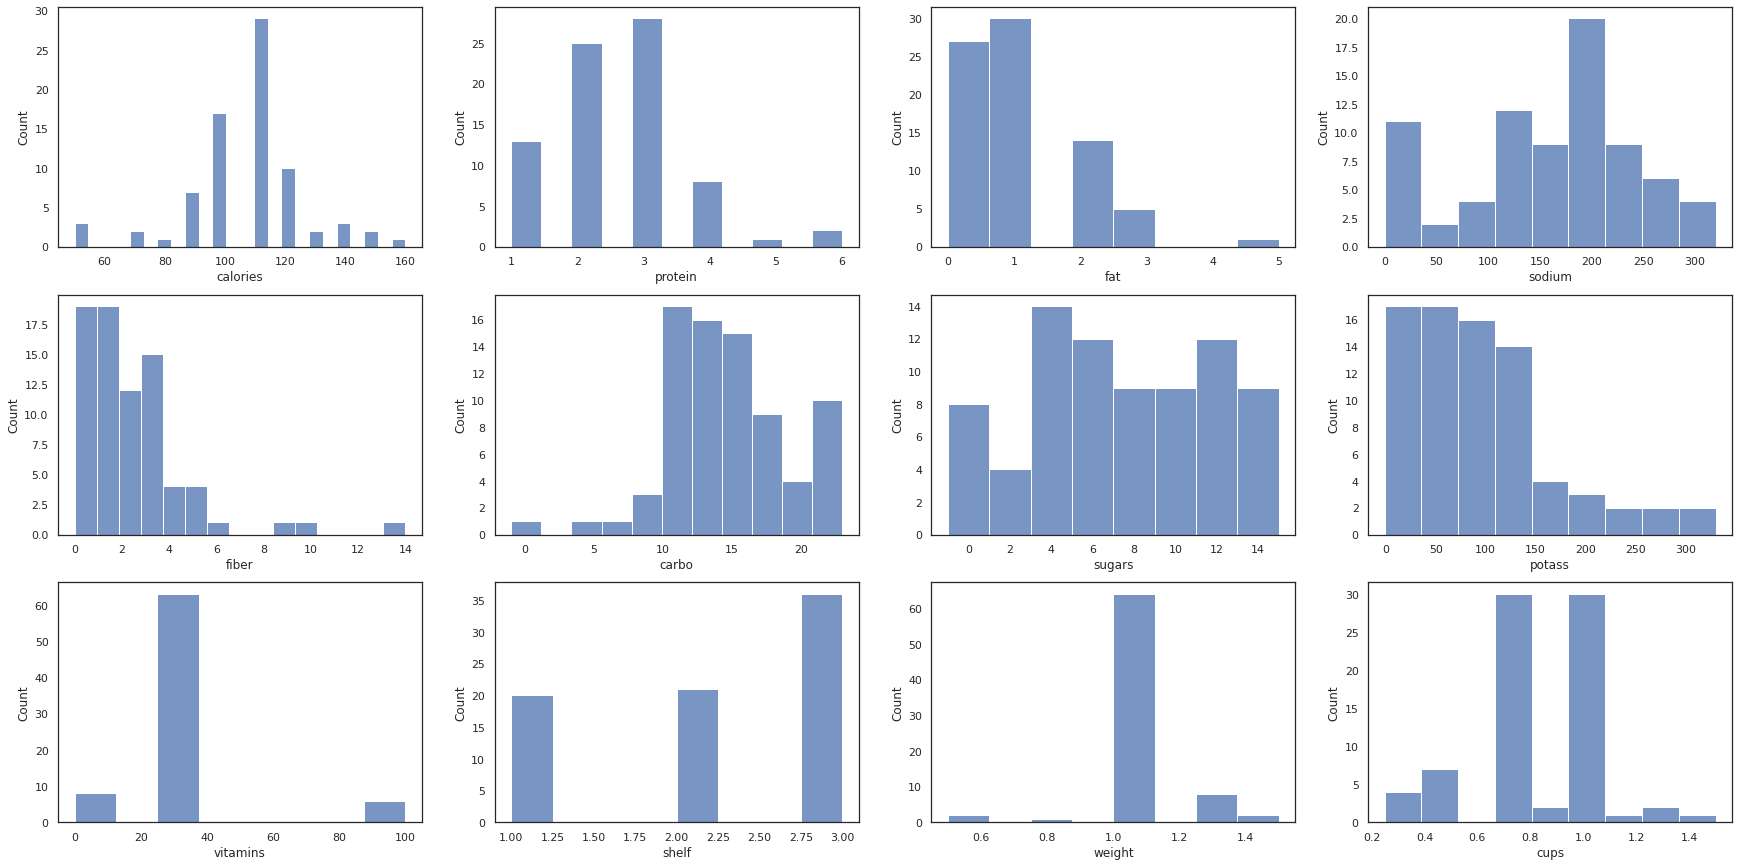

In [947]:
columns_to_plot = [ col for col in dataframe.select_dtypes(include=np.number).columns if col not in [ TARGET_VARIABLE ] ]

sns.set_theme(style='white')
subplots_grid_visualizer(
  dataframe=dataframe,
  columns=columns_to_plot,
  n_cols=4,
  visualizer=lambda df_subplot, index, col, ax, color_palette: (
    sns.histplot(data=df_subplot, ax=ax, x=col)
  ),
  subplot_col_width = 7.5,
  subplot_col_height = 5,
  subplots_adjustment={
    'wspace': 0.2,
    'hspace': 0.2,
  }
)

#### Overall at once

We can see all of them put together into one single plot, as they're on different scales, some daya is "lost", but we can sort of see it's outliers still. and how they're shaped

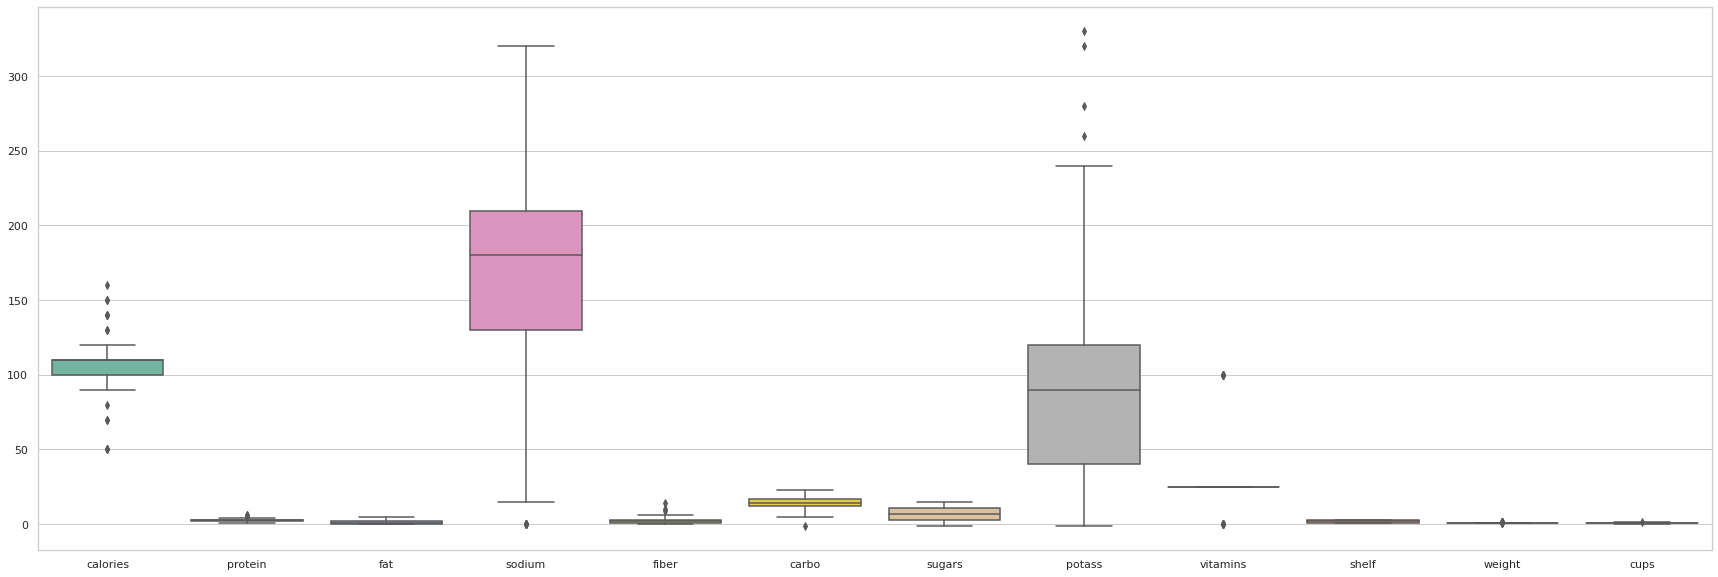

In [946]:
to_exlude = [
  'type',
  'mfr',
  # too high for a boxplot, un/comment at your own will
  # 'calories',
  # 'sodium',
  # 'potass'
]
# columns selection
columns_to_boxplot = [ col for col in columns_to_plot if col not in to_exlude ]

# Box plot
sns.set_theme(style='whitegrid')
plt.figure(figsize=(30,10))
_ = sns.boxplot(data=dataframe[ columns_to_boxplot ], orient='v', palette='Set2')

#### Overall with boxplots

We can see each individual feature's distribution in the boxplot, a nicer representation for, not only distribution, but outliers.

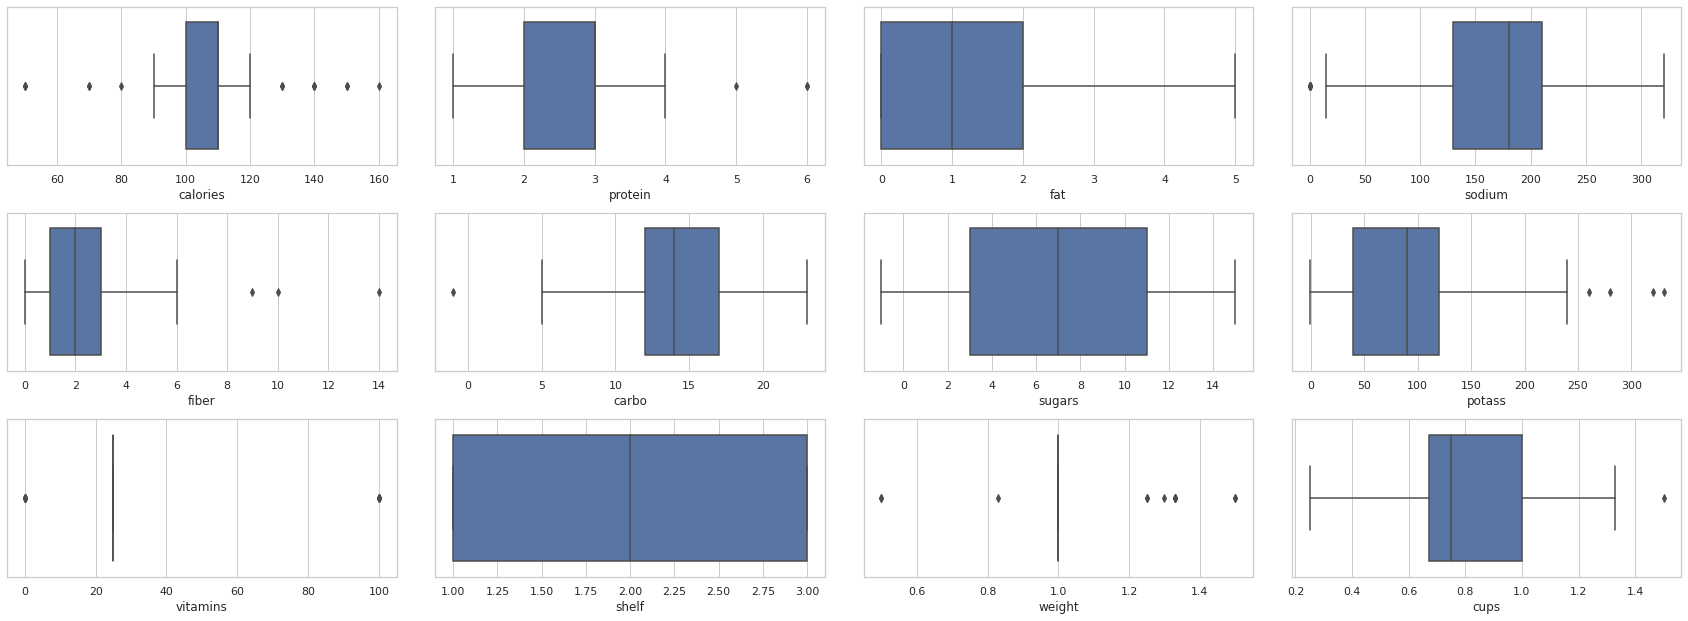

In [944]:
sns.set_theme(style="whitegrid")
subplots_grid_visualizer(
  dataframe=dataframe,
  columns=columns_to_plot,
  n_cols=4,
  visualizer=lambda df_subplot, index, col, ax, color_palette: (
    sns.boxplot(data=df_subplot, ax=ax, x=col, orient='h')
  ),
  subplot_col_width = 7.5,
  subplot_col_height = 3.5,
  subplots_adjustment={
    'wspace': 0.1,
    'hspace': 0.3,
  }
)

### Correlation

Some values may be too dependant of each other, or they may represent exactly the same information, which is not what we want.
There are exceptions, there may be values that are too codependant but with domain knowledge we know they're not.

But plotting the correlation can also help us see which values may contribute more to our dependant variable.

It's evaluated on absolute values as to more clearly identify high codependance

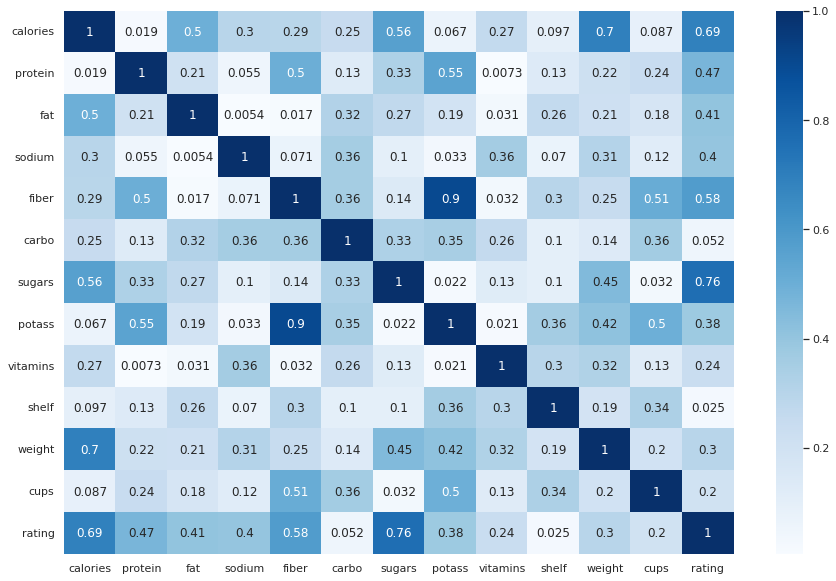

In [951]:
plt.figure(figsize=(15, 10))
_ = sns.heatmap(
  dataframe.corr().abs(),
  # dataframe.corr(),
  annot=True,
  fmt='.2g',
  cmap='Blues',
)

### Dependency on the dependant variable

The more of a diagonal or some sort of shape the plot has, the more it actually may explain our target variable. Scatterplot was just too small, probably due to the low number of data we're working with

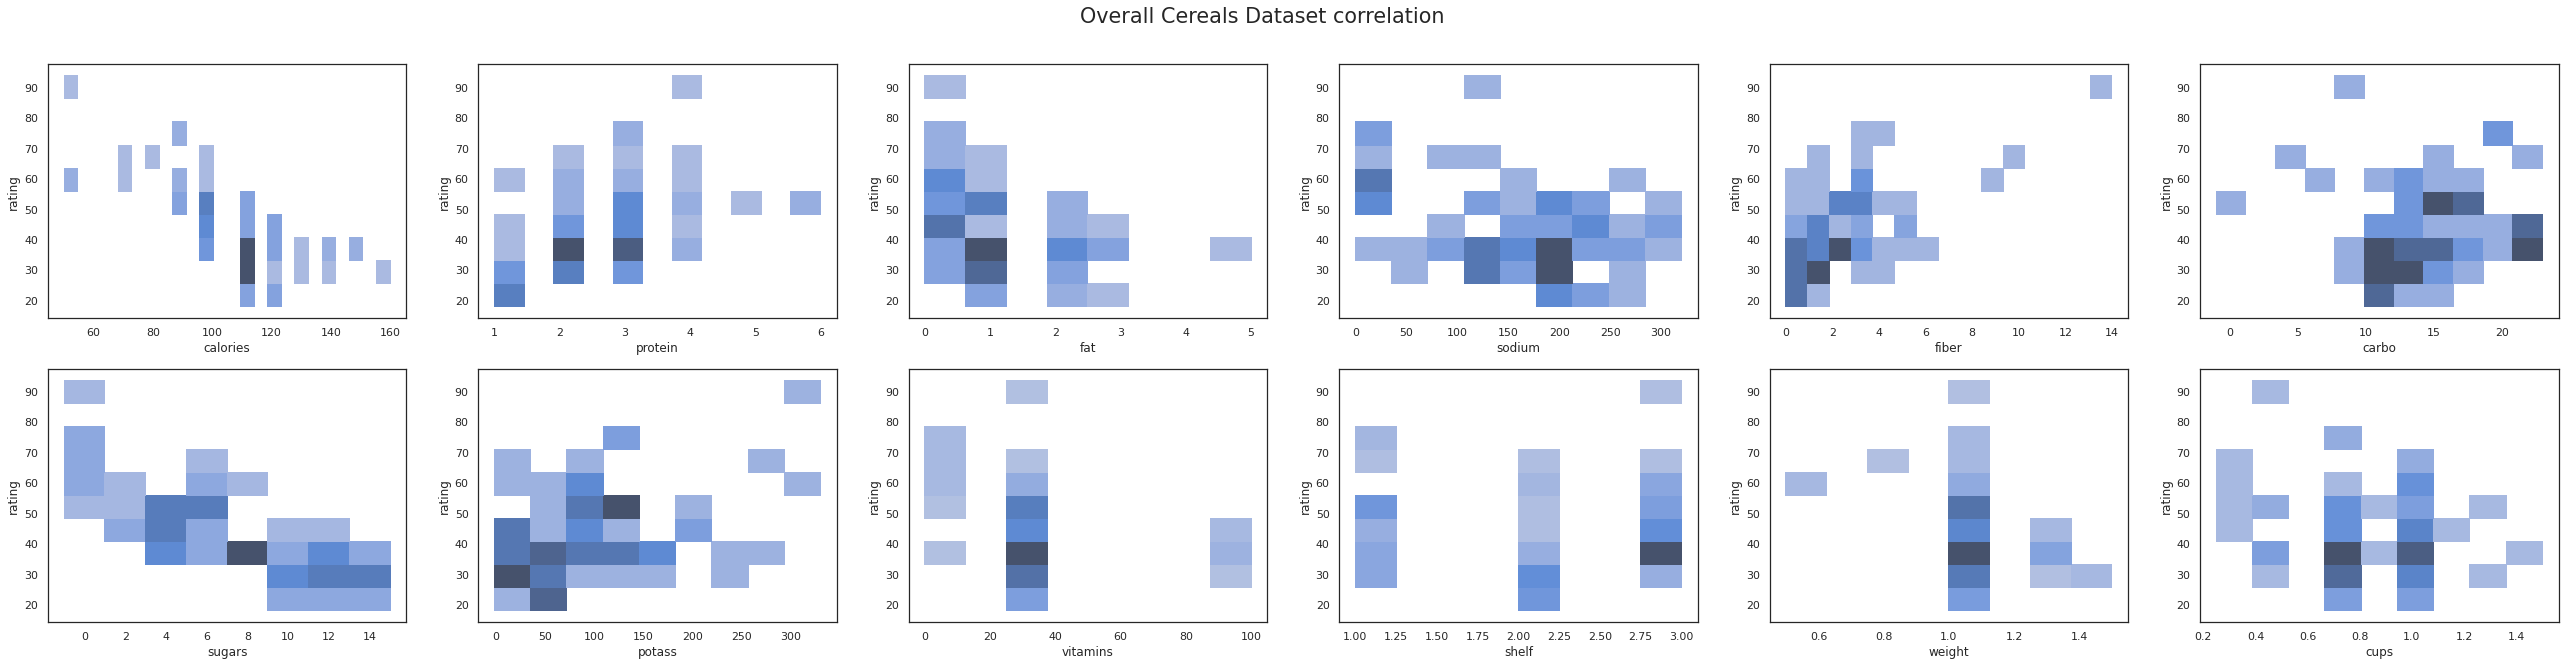

In [955]:
# correlation_columns = dataframe.columns
correlation_columns = dataframe.select_dtypes(include=np.number).columns
correlation_columns_to_ignore = [
  'name',
  TARGET_VARIABLE,
]
correlation_columns_to_plot = [ col for col in correlation_columns if col not in [ 'name', TARGET_VARIABLE ] ]
sns.set_theme(style="white")

def correlation_visualizer(df_subplot, index, col, ax, color_palette) -> None:
  # temp_correlation_plot = sns.scatterplot(
  # Good for the shape clarity
  temp_correlation_plot = sns.histplot(
  # Good to evaluate a direct correlation
  # temp_correlation_plot = sns.lineplot(
    data=df_subplot,
    x=col,
    y=TARGET_VARIABLE,
    # alpha=.75,
    ax=ax,
    # palette=color_palette[index % 8],
    palette=color_palette,
    # kde=True,
  )
  # temp_correlation_plot.set_title(col.title(), fontsize='x-large')

subplots_grid_visualizer(
  title='Overall Cereals Dataset correlation',
  dataframe=dataframe,
  columns=correlation_columns_to_plot,
  n_cols=6,
  visualizer=correlation_visualizer,
  subplots_adjustment={
    # 'top': 0.95,
    'top': 0.9,
    'bottom': None,
    'wspace': 0.2,
    'hspace': 0.2,
  }
)

### What are we trying to predict?

The rating, but what's it's shape, visualizing the values we're trying to predict can give us direct knowledge as to what algorithm fits best this problem.

But first we'll need to sort all of the values as to better understand and plot it's progression

In [911]:
sort_temp_df = dataframe.copy()
sort_temp_df = sort_temp_df.sort_values(by=['rating'], ignore_index=True)

And let's also configure the visualization theme of our prediction plot

In [919]:
sns.set_theme(style="ticks")

With dots, faster, and also let us know that the outlier at the top is not part of the flow

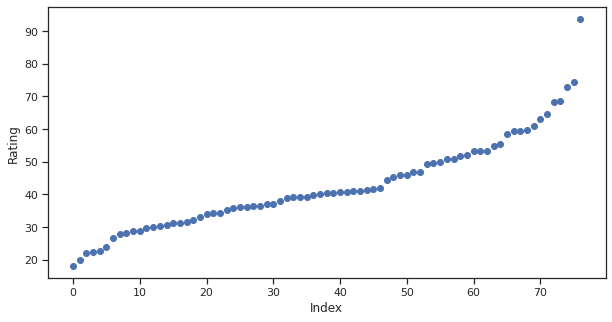

In [30]:
plt.figure(figsize=(10, 5))

plt.scatter(x=sort_temp_df.rating.index, y=sort_temp_df.rating)

_ = plt.xlabel('Index')
_ = plt.ylabel('Rating')

With a line, it's easier to understand, but may lead to some confusing conclusion, such as tthe last line, one may think it's part of the line, but it's just an outlier dot that was joined by a line

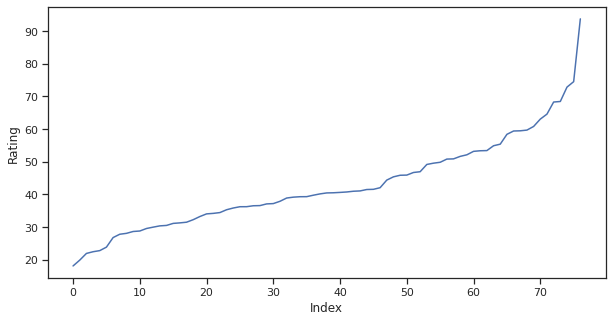

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(sort_temp_df.rating.index, sort_temp_df.rating)

_ = plt.xlabel('Index')
_ = plt.ylabel('Rating')

With less rendering iteration steps we can see clearer line that'd be closed to what we should aspire to achieve with our model

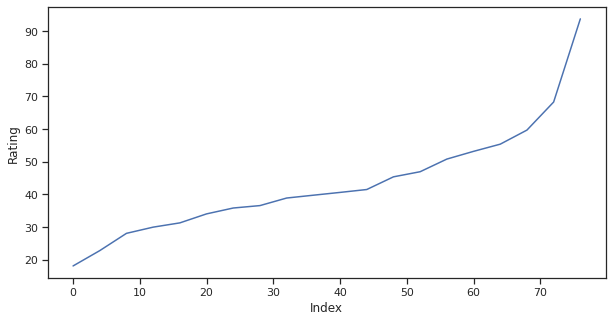

In [923]:
plt.figure(figsize=(10, 5))

# the less steps the more detailed
steps = 4
# steps = 5

# the stepped dataframe jumping by n intervals
stepped_sort_temp_df = sort_temp_df[::steps]
plt.plot(stepped_sort_temp_df.rating.index, stepped_sort_temp_df.rating)

_ = plt.xlabel('Index')
_ = plt.ylabel('Rating')

## Data Analysis

This will be just a some getting to know the data kind of analysis. I have a couple of questions and I'd like to see how this dataset is able to provide the anwers

### Preparation

This is a quick sanitization and preparation, not a deep, exhaustive and good one. But effective, nonetheless.

In [491]:
df_clean = dataframe.copy(deep=True)

Remove abnormal values

In [492]:
df_clean = df_clean[ df_clean['carbo'] >= 0.0 ]
df_clean = df_clean[ df_clean['sugars'] >= 0.0 ]
df_clean = df_clean[ df_clean['potass'] >= 0.0 ]

Translation the manufacturers for an easier human understanding

In [493]:
df_clean['mfr'] = df_clean['mfr'].apply( lambda x: manufacturer_dict[x] )

Also, translating the type for an easier human understanding

In [498]:
df_clean['type'] = df_clean['type'].apply( lambda x: type_dict[x] )

### Sugar per manufacturer

- Are there manufacturers that are too "sugary"?
- Have some manufacturers made a market for themselves just by adding too much suggar?
- Are there manufacturers that are as sugar-free as possible?

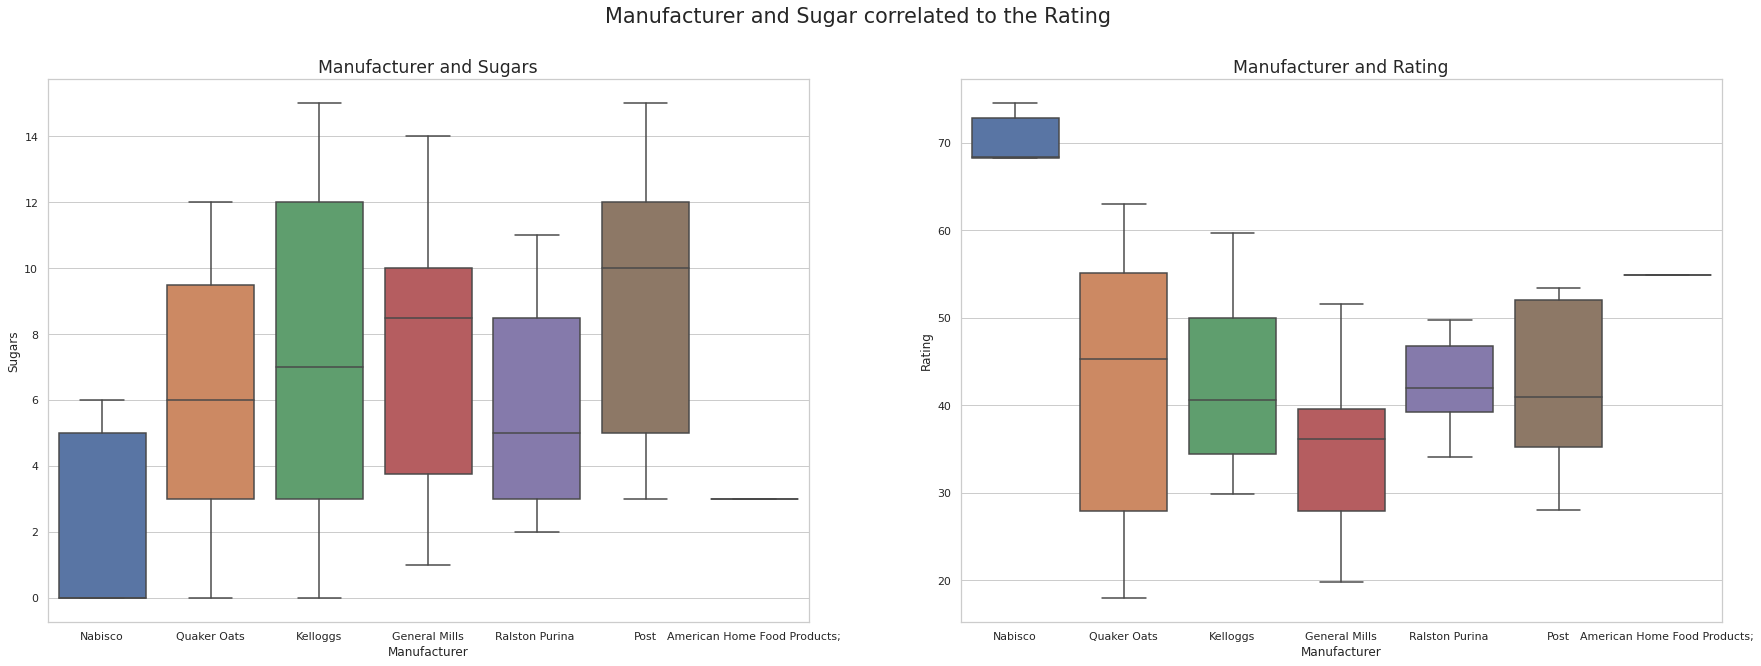

In [234]:
# manufacturer translation mapping
df_mfr = df_clean.copy(deep=True)
# df_mfr['mfr'] = df_mfr['mfr'].apply( lambda x: manufacturer_dict[x] )
# sanitizing foor this example
df_mfr = df_mfr[df_mfr['sugars'] >= 0.0]

# Subplots initialization
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
plt.suptitle( 'Manufacturer and Sugar correlated to the Rating', fontsize='xx-large', )

# Manufacturer and Sugars
_ = sns.boxplot( data=df_mfr, x='mfr', y='sugars', ax=axes[0], showfliers=False, )
axes[0].set_title( 'Manufacturer and Sugars', fontsize='x-large', )
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Sugars')

# Manufacturer and Rating
_ = sns.boxplot( data=df_mfr, x='mfr', y=TARGET_VARIABLE, ax=axes[1], showfliers=False, )
axes[1].set_title( 'Manufacturer and Rating', fontsize='x-large', )
axes[1].set_xlabel('Manufacturer')
_ = axes[1].set_ylabel('Rating')

We kind of have some answers:

- Are there manufacturers that are too "sugary"?
 - Yes, there are, quite of them in this dataset actually.
- Have some manufacturers made a market for themselves just by adding too much.suggar?
 - Yes; General Mills and Post seem to be leading that market.
- Are there manufacturers that are as sugar-free as possible?
 - If I were to pick healthier options, Nabisco would come on top, and Kellogs.is just selling on everything, but Nabisco has a better rating at that.

### Nutritional facts

This won't be a nutritional report, as I'm no expert at that, but the amount of calories is a contribution of many nutritional attributes, let's see how they play out in this dataset.

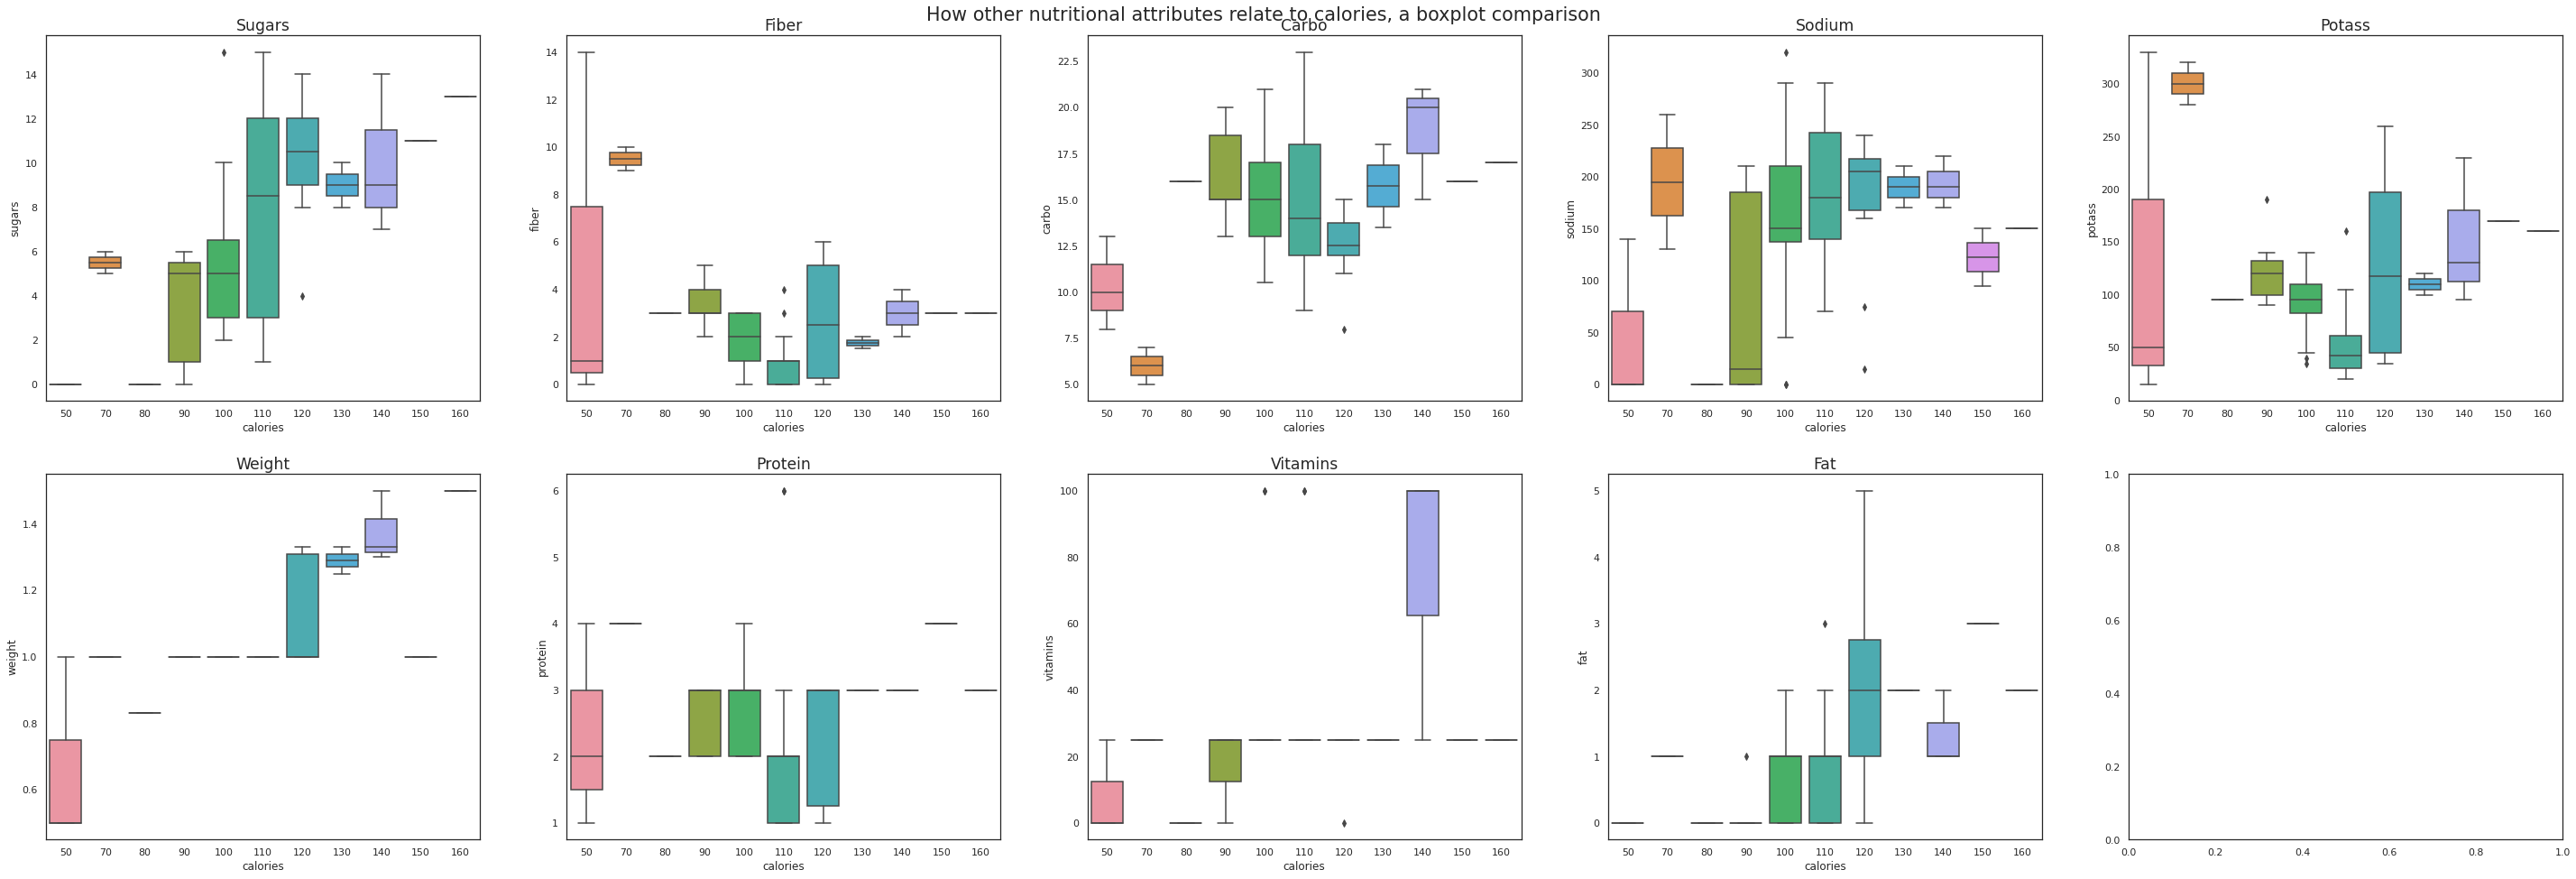

In [963]:
# nutritional columns to fact-check
nutritional_columns = [
  'sugars',
  'fiber',
  'carbo',
  'sodium',
  'potass',
  'weight',
  # added later
  'protein',
  'vitamins',
  'fat',
]

def nutritional_attribute_visualizer(df_subplot, index, col, ax, color_palette) -> None:
  # Lineplot displays a clearer correlation
  # _ = sns.lineplot(
  # Boxplot gives a more accurate estimation
  _ = sns.boxplot(
    data=df_subplot,
    x='calories',
    y=col,
    # label=nutritional_column.title(),
    ax=ax,
    # dodge=False,
    # showfliers=False,
    # palette=color_palette,
  )
  ax.set_title(col.title(), fontsize='x-large')

sns.set_theme(style='white')
subplots_grid_visualizer(
  title='How other nutritional attributes relate to calories, a boxplot comparison',
  dataframe=df_clean,
  columns=nutritional_columns,
  n_cols=5,
  subplot_col_width = 10,
  subplot_col_height = 7.5,
  visualizer=nutritional_attribute_visualizer,
  subplots_adjustment={
    'top': 0.95,
    # 'top': 0.9,
    'bottom': None,
    'wspace': 0.2,
    'hspace': 0.2,
  }
)

### Most/Least of each nutritional attributes

Let's see the best and worst rated of each nutritional attribute in a table layout

A helper function to get the head and tail of a dataframe sorted by the given attribute

In [517]:
def most_least_attribute(
  dataframe: pd.DataFrame,
  attribute: str,
  amount: int = 1,
  ascending: bool = False,
  restrictive: bool = True,
  include_most: bool = True,
  include_least: bool = True,
) -> pd.DataFrame:
  security_condition = attribute in dataframe.columns

  if restrictive:
    assert security_condition
  elif not security_condition:
    return dataframe

  df_copy = dataframe.copy(deep=True)
  df_copy_sorted = df_copy.sort_values( by=attribute, ascending=ascending, )

  concat_dfs = []

  if include_most:
    concat_dfs.append(df_copy_sorted.head(amount))
  if include_least:
    concat_dfs.append(df_copy_sorted.tail(amount))

  return pd.concat(concat_dfs)

#### Visualize them

In [534]:
nutritional_attributes = [
  'calories',
  'sugars',
  'fiber',
  'potass',
  'weight',
  'protein',
  'carbo',
  'vitamins',
  'sodium',
  'fat',
  # not nutritional, but we can also take a look into it
  'shelf',
  'cups',
  # not a nutritional value, bust just out of sheer curiosity
  'rating',
]
most_least_amount = 3

def visualize_most_least(
  nutritional_attribute: str
) -> None:
  temp_df_most_least = most_least_attribute(
    df_clean,
    nutritional_attribute,
    amount=most_least_amount
  )

  # nutritional attribute title
  print(
    '\n',
    nutritional_attribute.title(),
    '\n',
  )

  # dataframe
  display(temp_df_most_least)

_ = list(map(visualize_most_least, nutritional_attributes))


 Calories 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
46,Mueslix Crispy Blend,Kelloggs,Cold,160,3,2,150,3.0,17.0,13,160,25,3,1.5,0.67,30.313351
44,Muesli Raisins; Dates; & Almonds,Ralston Purina,Cold,150,4,3,95,3.0,16.0,11,170,25,3,1.0,1.00,37.136863
45,Muesli Raisins; Peaches; & Pecans,Ralston Purina,Cold,150,4,3,150,3.0,16.0,11,170,25,3,1.0,1.00,34.139765
3,All-Bran with Extra Fiber,Kelloggs,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.5,1.00,60.756112
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.5,1.00,63.005645



 Sugars 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
66,Smacks,Kelloggs,Cold,110,2,1,70,1.0,9.0,15,40,25,2,1.00,0.75,31.230054
30,Golden Crisp,Post,Cold,100,2,0,45,0.0,11.0,15,40,25,1,1.00,0.88,35.252444
70,Total Raisin Bran,General Mills,Cold,140,3,1,190,4.0,15.0,14,230,100,3,1.50,1.00,28.592785
64,Shredded Wheat 'n'Bran,Nabisco,Cold,90,3,0,0,4.0,19.0,0,140,0,1,1.00,0.67,74.472949
63,Shredded Wheat,Nabisco,Cold,80,2,0,0,3.0,16.0,0,95,0,1,0.83,1.00,68.235885
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.50,1.00,63.005645



 Fiber 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
3,All-Bran with Extra Fiber,Kelloggs,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
2,All-Bran,Kelloggs,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
37,Honey-comb,Post,Cold,110,1,0,180,0.0,14.0,11,35,25,1,1.0,1.33,28.742414
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.5,1.00,60.756112
18,Count Chocula,General Mills,Cold,110,1,1,180,0.0,12.0,13,65,25,2,1.0,1.00,22.396513



 Potass 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
3,All-Bran with Extra Fiber,Kelloggs,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
2,All-Bran,Kelloggs,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
29,Fruity Pebbles,Post,Cold,110,1,1,135,0.0,13.0,12,25,25,2,1.0,0.75,28.025765
17,Corn Pops,Kelloggs,Cold,110,1,0,90,1.0,13.0,12,20,25,2,1.0,1.00,35.782791
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.5,1.00,60.756112



 Weight 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
70,Total Raisin Bran,General Mills,Cold,140,3,1,190,4.0,15.0,14,230,100,3,1.50,1.00,28.592785
46,Mueslix Crispy Blend,Kelloggs,Cold,160,3,2,150,3.0,17.0,13,160,25,3,1.50,0.67,30.313351
58,Raisin Bran,Kelloggs,Cold,120,3,1,210,5.0,14.0,12,240,25,2,1.33,0.75,39.259197
63,Shredded Wheat,Nabisco,Cold,80,2,0,0,3.0,16.0,0,95,0,1,0.83,1.00,68.235885
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.50,1.00,60.756112
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.50,1.00,63.005645



 Protein 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
67,Special K,Kelloggs,Cold,110,6,0,230,1.0,16.0,3,55,25,1,1.0,1.00,53.131324
11,Cheerios,General Mills,Cold,110,6,2,290,2.0,17.0,1,105,25,1,1.0,1.25,50.764999
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
35,Honey Graham Ohs,Quaker Oats,Cold,120,1,2,220,1.0,12.0,11,45,25,2,1.0,1.00,21.871292
29,Fruity Pebbles,Post,Cold,110,1,1,135,0.0,13.0,12,25,25,2,1.0,0.75,28.025765
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.5,1.00,60.756112



 Carbo 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
61,Rice Chex,Ralston Purina,Cold,110,1,0,240,0.0,23.0,2,30,25,1,1.0,1.13,41.998933
15,Corn Chex,Ralston Purina,Cold,110,2,0,280,0.0,22.0,3,25,25,1,1.0,1.00,41.445019
62,Rice Krispies,Kelloggs,Cold,110,2,0,290,0.0,22.0,3,35,25,1,1.0,1.00,40.560159
3,All-Bran with Extra Fiber,Kelloggs,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
2,All-Bran,Kelloggs,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973



 Vitamins 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
39,Just Right Fruit & Nut,Kelloggs,Cold,140,3,1,170,2.0,20.0,9,95,100,3,1.30,0.75,36.471512
71,Total Whole Grain,General Mills,Cold,100,3,1,200,3.0,16.0,3,110,100,3,1.00,1.00,46.658844
69,Total Corn Flakes,General Mills,Cold,110,2,1,200,0.0,21.0,3,35,100,3,1.00,1.00,38.839746
63,Shredded Wheat,Nabisco,Cold,80,2,0,0,3.0,16.0,0,95,0,1,0.83,1.00,68.235885
1,100% Natural Bran,Quaker Oats,Cold,120,3,5,15,2.0,8.0,8,135,0,3,1.00,1.00,33.983679
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.50,1.00,63.005645



 Sodium 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
53,Product 19,Kelloggs,Cold,100,3,0,320,1.0,20.0,3,45,100,3,1.0,1.0,41.503540
62,Rice Krispies,Kelloggs,Cold,110,2,0,290,0.0,22.0,3,35,25,1,1.0,1.0,40.560159
16,Corn Flakes,Kelloggs,Cold,100,2,0,290,1.0,21.0,2,35,25,1,1.0,1.0,45.863324
55,Puffed Wheat,Quaker Oats,Cold,50,2,0,0,1.0,10.0,0,50,0,3,0.5,1.0,63.005645
54,Puffed Rice,Quaker Oats,Cold,50,1,0,0,0.0,13.0,0,15,0,3,0.5,1.0,60.756112
60,Raisin Squares,Kelloggs,Cold,90,2,0,0,2.0,15.0,6,110,25,3,1.0,0.5,55.333142



 Fat 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
1,100% Natural Bran,Quaker Oats,Cold,120,3,5,15,2.0,8.0,8,135,0,3,1.00,1.00,33.983679
12,Cinnamon Toast Crunch,General Mills,Cold,120,1,3,210,0.0,13.0,9,45,25,2,1.00,0.75,19.823573
34,Great Grains Pecan,Post,Cold,120,3,3,75,3.0,13.0,4,100,25,3,1.00,0.33,45.811716
50,Nutri-grain Wheat,Kelloggs,Cold,90,3,0,170,3.0,18.0,2,90,25,3,1.00,1.00,59.642837
28,Fruitful Bran,Kelloggs,Cold,120,3,0,240,5.0,14.0,12,190,25,3,1.33,0.67,41.015492
37,Honey-comb,Post,Cold,110,1,0,180,0.0,14.0,11,35,25,1,1.00,1.33,28.742414



 Shelf 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.00,0.33,68.402973
51,Oatmeal Raisin Crisp,General Mills,Cold,130,3,2,170,1.5,13.5,10,120,25,3,1.25,0.50,30.450843
32,Grape Nuts Flakes,Post,Cold,100,3,1,140,3.0,15.0,5,85,25,3,1.00,0.88,52.076897
11,Cheerios,General Mills,Cold,110,6,2,290,2.0,17.0,1,105,25,1,1.00,1.25,50.764999
15,Corn Chex,Ralston Purina,Cold,110,2,0,280,0.0,22.0,3,25,25,1,1.00,1.00,41.445019
76,Wheaties Honey Gold,General Mills,Cold,110,2,1,200,1.0,16.0,8,60,25,1,1.00,0.75,36.187559



 Cups 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
40,Kix,General Mills,Cold,110,2,1,260,0.0,21.0,3,40,25,2,1.0,1.50,39.241114
37,Honey-comb,Post,Cold,110,1,0,180,0.0,14.0,11,35,25,1,1.0,1.33,28.742414
11,Cheerios,General Mills,Cold,110,6,2,290,2.0,17.0,1,105,25,1,1.0,1.25,50.764999
2,All-Bran,Kelloggs,Cold,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
0,100% Bran,Nabisco,Cold,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
33,Grape-Nuts,Post,Cold,110,3,0,170,3.0,17.0,3,90,25,3,1.0,0.25,53.371007



 Rating 



,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
3,All-Bran with Extra Fiber,Kelloggs,Cold,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
64,Shredded Wheat 'n'Bran,Nabisco,Cold,90,3,0,0,4.0,19.0,0,140,0,1,1.0,0.67,74.472949
65,Shredded Wheat spoon size,Nabisco,Cold,90,3,0,0,3.0,20.0,0,120,0,1,1.0,0.67,72.801787
35,Honey Graham Ohs,Quaker Oats,Cold,120,1,2,220,1.0,12.0,11,45,25,2,1.0,1.00,21.871292
12,Cinnamon Toast Crunch,General Mills,Cold,120,1,3,210,0.0,13.0,9,45,25,2,1.0,0.75,19.823573
10,Cap'n'Crunch,Quaker Oats,Cold,120,1,2,220,0.0,12.0,12,35,25,2,1.0,0.75,18.042851


## Data Cleansening

We have to clean our data, all of our data must be quality data, cleaned as in, no missing values, no abnormal values, nothing we consider, as for this project, weird.

### Backup

It is a good practice to always create some sort of backup of our original dataset so we can modify on a mirrored example.

In [652]:
df = dataframe.copy(deep=True)

### Cleaning

Remove those attributes that will just add noise

The type barely has any variation, it's distribution it's almost non-existant, so it's unnecessary for now

In [653]:
df = df.drop(columns=[
  'type',
])

Let's also clean the dataframe from unbalanced values, given that the manufaturer was proven not to be an important factor for this project, there's no need to take that into account

In [654]:
len(df)

77

In [755]:
# df = df[df['mfr'] != 'A']

In [656]:
len(df)

77

### Abnormal values

Let's treat those nutritional values that had negative integers

In [657]:
len(df)

77

In [658]:
df = df[ df['carbo'] >= 0.0 ]
df = df[ df['sugars'] >= 0.0 ]
df = df[ df['potass'] >= 0.0 ]

In [659]:
len(df)

74

## Data Preprocessing

We now have clean data, but it is not fully ready and transformed for our model to understand it, we need to make sure that it's all numeric, as much as possible.

And we need to decide which scaler we'll use for our data, which type of normalization fits best our dataset.

### Standarization

Standarization is the process of making all of the data be understandable in the same manner, to make it numeric, map it, transform it, do whatever mutation is needed for our model to understand it.

#### Manufacturer

It has a finite number of options it can take, they're string label-encoded values.

In [660]:
df['mfr'].unique()

array(['N', 'Q', 'K', 'G', 'R', 'P', 'A'], dtype=object)

So it gets factorized into a dictionary

In [661]:
df['mfr'] = pd.factorize(df['mfr'])[0]

#### Product name

Name can also be vectorized, or converted to a dictionary, let's see how both ways play out to see which one adapts better to our needs

Factorized would turn the names into an id, that wouldn't be too good

In [662]:
pd.factorize(df['name'])[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

Let's use a word tokenizer from the NLTK (Natural Language ToolKit). Which doesn't seem a good fit either for this project

In [663]:
import nltk
nltk.download('punkt')

df.apply(lambda row: nltk.word_tokenize(row['name']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0                     [100, %, Bran]
1            [100, %, Natural, Bran]
2                         [All-Bran]
3     [All-Bran, with, Extra, Fiber]
5        [Apple, Cinnamon, Cheerios]
                   ...              
72                         [Triples]
73                            [Trix]
74                     [Wheat, Chex]
75                        [Wheaties]
76           [Wheaties, Honey, Gold]
Length: 74, dtype: object

There's an option to Count Vectorize the words, but we'd fall into having an id column, an unsorted one, sure, but still an id column, given how little examples we do have.

We could, and will, ignore the name and carry on, we'll leave it there as reference, but we won't compute it.

### Normalization

We'll use pipelines, so no need to normalize just now, we'll let the pipelines handle all of that process.

Normalization is the process which ensures that all of our dataset will use the same scale, from 0 to 1, leading the standard deviation to as minimum as possible, in other words, as close to zero as we can.

In [664]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

In [665]:
scaled_dataframes = []

In [666]:
scalers = [
  ('MinMaxScaler', MinMaxScaler()),
  ('MaxAbsScaler', MaxAbsScaler()),
  ('StandardScaler', StandardScaler()),
  ('RobustScaler', RobustScaler()),
]

In [667]:
for scaler_details in scalers:
  scaler_name, scaler_model = scaler_details
  scaled_dataframes.append((
    scaler_name,
    scaler_model.fit_transform(df[[col for col in df.columns if col != 'name']]),
  ))

#### Scaler selection

We'll use subplots to visually understand how the different scalers normalize and affect our data, we'll use boxplot because of the outliers.

Knowing what's a scaler, we'll look for the scaler that best fits our dataset

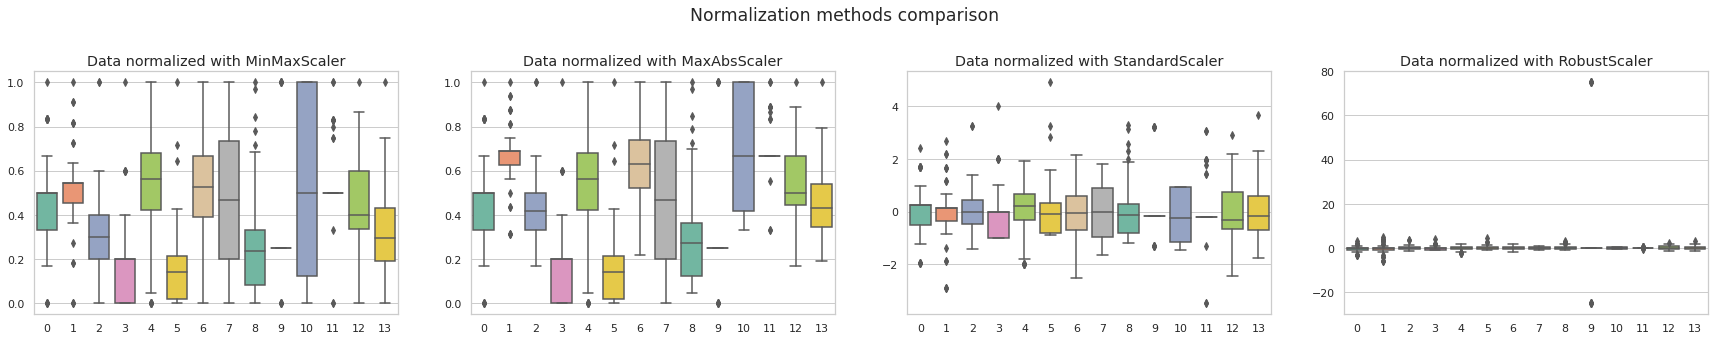

In [668]:
# subplot configuration
n_scalers = len(scaled_dataframes)
scaler_col_width = 7.5

# subplot initialization
fig, axes = plt.subplots(1, n_scalers, figsize=(n_scalers * scaler_col_width, 5))
sns.set_theme(style='whitegrid')
fig.suptitle('Normalization methods comparison', fontsize='x-large')
fig.subplots_adjust(top=0.8)

# boxplots
for index, scaler_details in enumerate(scaled_dataframes):
  scaler_name, scaled_data = scaler_details
  _ = sns.boxplot(data=scaled_data, orient='v', palette='Set2', ax=axes[index])
  _.set_title(f'Data normalized with {scaler_name}', fontsize='large')

MinMaxScaler is an incredible option as it takes into account the outliers, but there are columns in which it gives them too much importance, making the actual values lose value.

MaxAbsScaler on the other hand, while being conscious of the outliers, respects the actual scale of the values while unifying them between zero and one.

#### Selected scaler

Now that we've selected our scaler, `MaxAbsScaler`, let uas plot to see, in detail, how our data will be represented

In [669]:
# SELECTED_NORMALIZATION_SCALER = MinMaxScaler
SELECTED_NORMALIZATION_SCALER = MaxAbsScaler

In [670]:
distribution_scaler = SELECTED_NORMALIZATION_SCALER()
df_distribution_scaled_data = pd.DataFrame(
  distribution_scaler.fit_transform(df[[col for col in df.columns if col != 'name']]),
  columns=distribution_scaler.feature_names_in_,
)

<Figure size 432x288 with 0 Axes>

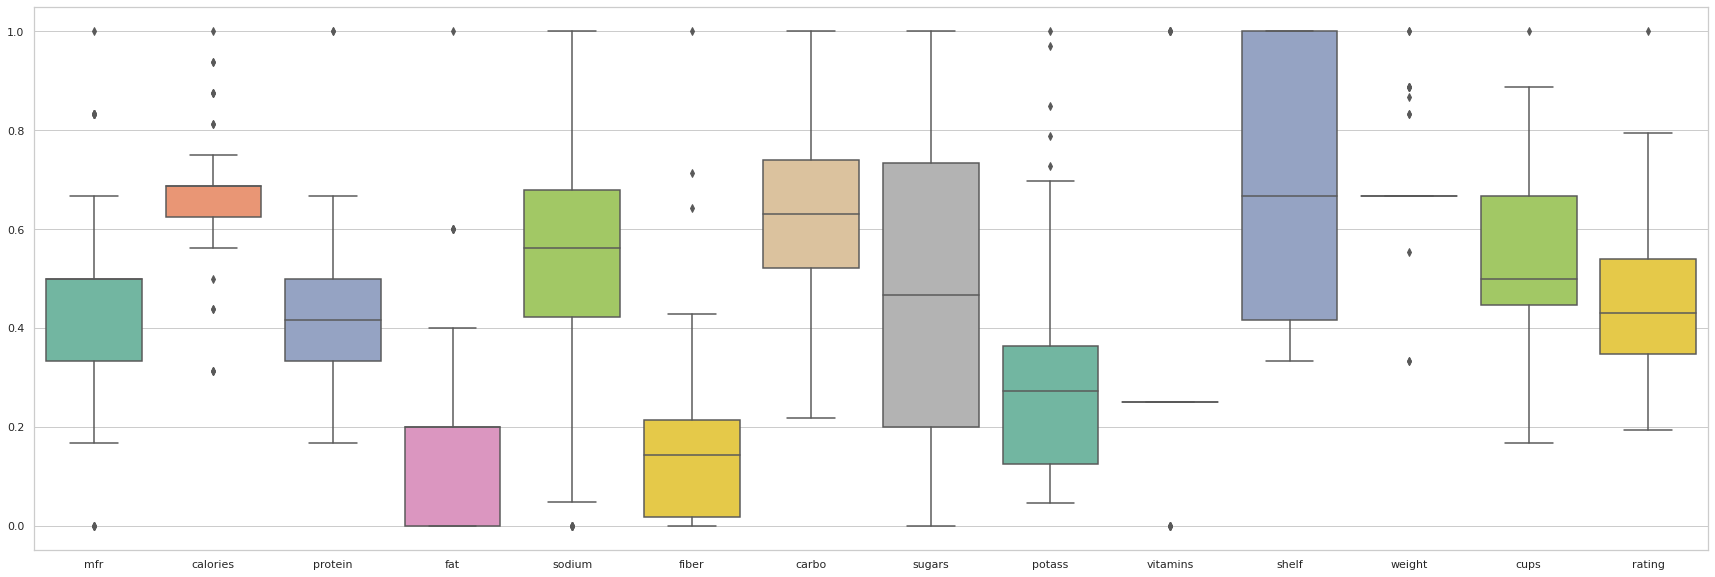

In [671]:
plt.suptitle('Normalization with the selecte scaler', fontsize='xx-large')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 10))
_ = sns.boxplot(data=df_distribution_scaled_data, orient="v", palette="Set2")

#### Histplot

The detailed version it's too confusing but it can give some insights.

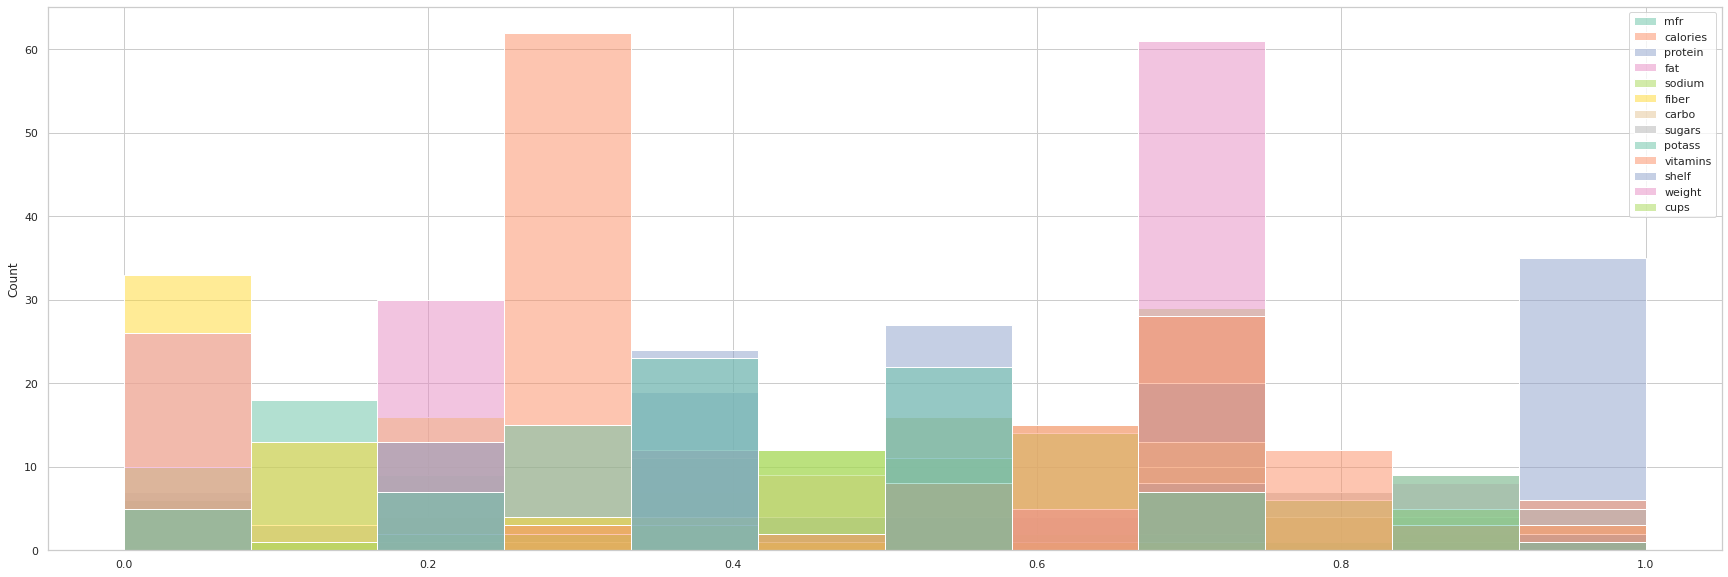

In [964]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 10))
_ = sns.histplot(
  data=df_distribution_scaled_data[
    [
      col
      for col in df_distribution_scaled_data.columns
      if col != TARGET_VARIABLE
    ]
  ],
  palette="Set2"
)

## Data preparation

From this point forward, the data will be ready for the modelling, so, assignments, train/test splitting and label and data distinction should be done in this section.

### Assignment

Here we'll create our data and labels, and we'll ignore all of the columns that we may not need, for now

In [673]:
# Trabaja muchísimo mejor con toda la información, es por ello que merece la pena no eliminar por correlación ningún valor
# untrainable_cols = [target, 'mfr', 'protein', 'shelf', 'sugars']
ignore_cols = [
  TARGET_VARIABLE,
  # tokenizing the name to analyze it's possible human attraction would be out of the scope of this project
  'name',
  # given the linear regression coefficients, they almost don't contribute at all, 0-7e aprox.
  'shelf',
  'weight',
  'cups',
  'mfr',
]
columns = [ col for col in df.columns if col not in ignore_cols ]

In [674]:
X = df[ columns ]
y = df[ TARGET_VARIABLE ]

In [675]:
# RANDOM_SEED=238758375
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

### Data splitting

We need to split the data into three different sets, optimally, two can suffice, but no less than two:

- Train, the set of the data from which our model will learn
- Validation, optional, helps to keep track of the model's progress and can serve as another test set
- Test/Production, the set of the data will validate our model's performance, this will be data that our model has never seen before

In [676]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)

## Data Science

Here we'll start modelling our data, trying out and tuning algorithms. We already saw how the progression of the values is linear.

So Linear Regression should suffice, with some modifications that is to say.
But we'll also try Support Vector Machine Regressor for a better adaptability

### Imports

In [970]:
# Preprocessing
from sklearn.preprocessing import PolynomialFeatures
# Feature reduction
from sklearn.decomposition import PCA

# Utilities
from sklearn.pipeline import make_pipeline, Pipeline

# Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import r2_score

### Helpers

Some helper utilities so that modelling and checking it's metrics becomes muuuuch easier

#### Sets of data

Variables that store the sets of data and it's utilities

In [678]:
sets_of_data = {
  'test': (X_test, y_test),
  'val': (X_val, y_val),
  'train': (X_train, y_train),
  'total': (X, y),
}

In [679]:
performance_dict = { set_type: dict() for set_type in sets_of_data }

In [680]:
predictions_dict = { set_type: dict() for set_type in sets_of_data }

#### Evaluation

A utility function to test and store the performance and predictions of a model based on the different sets of data

In [681]:
def evaluate_model(
  model,
  name: str,
) -> None:
  global performance_dict, predictions_dict

  for set_type, set_values in sets_of_data.items():
    performance_dict[set_type][name] = model.score(*set_values)
    predictions_dict[set_type][name] = model.predict(set_values[0])

  # Test set
  display_score(performance_dict['test'][name])
  # Validation set
  display_score(performance_dict['val'][name])

#### Score

A helper function to format the score so it is standarized all throughout the notebooks

In [682]:
default_decimals = 3

def format_score(
  score: float,
  decimals: int = default_decimals
) -> float:
  return round(score * 100, decimals)

print(format_score(0.99999, 3))

99.999


In [683]:
def display_score(
  score: float,
  decimals: int = default_decimals
) -> None:
  formatted_score = format_score(score, decimals)
  print(f'{formatted_score}%')

#### Evaluate regression

We'll plot a regressor to compare it with the expected outcome to see how our model performed

In [684]:
def plot_regression(
  model,
  base_model: callable,
  y_true: pd.Series,
  X_true: pd.DataFrame,
  # y_lim_min: float = 0.0,
  # y_lim_max: float = 1.0,
  figsize: Tuple[float, float] = (20, 10)
) -> None:
  plt.figure(figsize=figsize)
  y_pred = model.predict(X_true)
  plt.scatter(
    y_true,
    y_pred,
    color='blue',
    # alpha=0.2,
  )
  # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')

  # squared error
  root_squared_error = r2_score(y_true, y_pred)

  # shift = .1
  # shift = 0
  shift = y_true.max() // 10

  # annotation
  ann_x, ann_y = (y_true.min() + shift, y_true.max() - shift)
  plt.annotate(
    'r-squared = {:.3f}'.format(root_squared_error),
    (ann_x, ann_y)
  )

  # limit the window view
  # plt.ylim(y_lim_min, y_lim_max)

  #regression line
  y_true, y_pred = np.array(y_true).reshape(-1,1), y_pred.reshape(-1,1)
  # plt.figure(figsize=figsize)
  plt.plot(y_true, base_model().fit(y_true, y_pred).predict(y_true), linewidth=4, color='red')

  # display de plot
  plt.show()

### Linear Regression

Linear regression solves a simple equation based on the linear correlation between vector `X` and vector `y`

In [685]:
def build_linear_regr_model() -> Pipeline:
  return Pipeline(
    steps=[
      ['scaler', SELECTED_NORMALIZATION_SCALER()],
      ['regr', LinearRegression()],
    ],
  )

In [686]:
linear_regr = build_linear_regr_model()
linear_regr.fit(X_train, y_train)

evaluate_model(linear_regr, 'linear_regr')

100.0%
100.0%


#### Regression

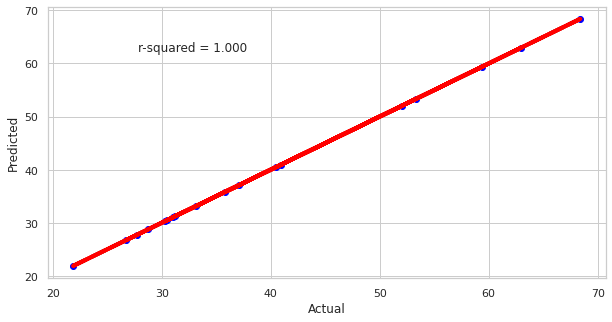

In [687]:
plot_regression(
  model=linear_regr,
  base_model=build_linear_regr_model,
  X_true=X_test,
  y_true=y_test,
  figsize=(10, 5)
)

#### Explainability

With Linear Regression, we can plot it's coefficients to see it's conclusions, from the inside out

In [688]:
df_linear_regr_explainability = pd.DataFrame(
  zip(
    X_train.columns,
    linear_regr['regr'].coef_
  ),
  columns=['feature', 'coefficient']
)

In [689]:
df_linear_regr_explainability['abs_coef'] = df_linear_regr_explainability['coefficient'].abs()

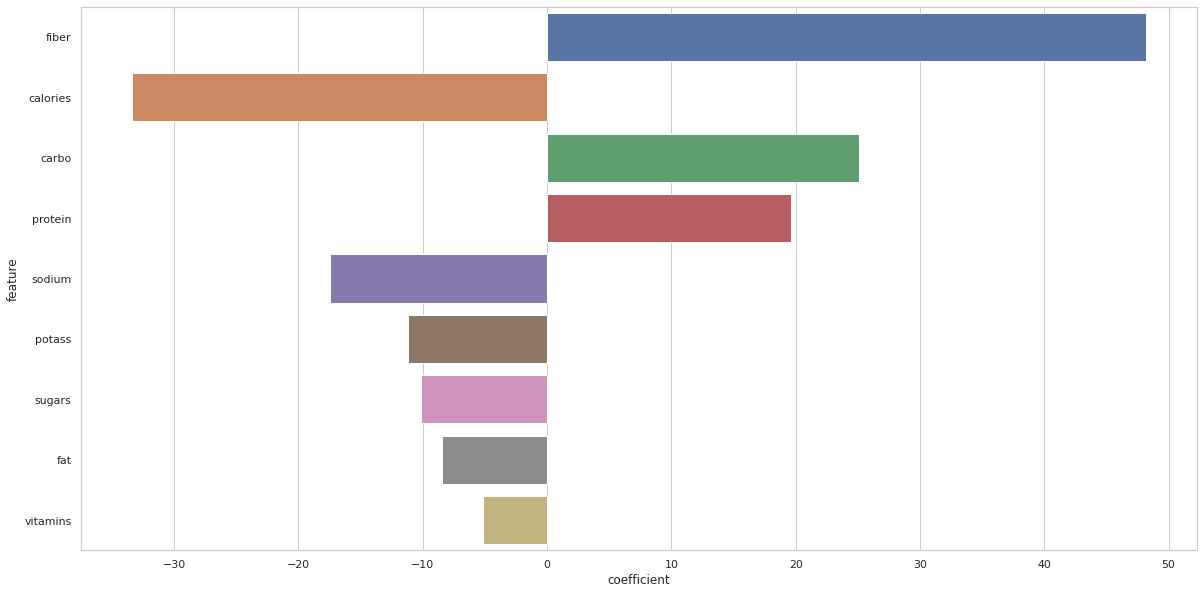

In [690]:
plt.figure(figsize=(20, 10))
_ = sns.barplot(
  data=(
    df_linear_regr_explainability
    .sort_values(by='abs_coef', ascending=False)
  ),
  x='coefficient',
  y='feature',
)

Let's see the top features that contribute the most to the rating

In [691]:
# pd.set_option('display.float_format', lambda x: '%.10f' % x)

(
  df_linear_regr_explainability
  .sort_values(by='abs_coef', ascending=False)[
    ['feature', 'coefficient']
  ]
)

,feature,coefficient
4,fiber,48.208716
0,calories,-33.408625
5,carbo,25.126372
1,protein,19.639043
3,sodium,-17.437665
7,potass,-11.217806
6,sugars,-10.148532
2,fat,-8.457040
8,vitamins,-5.121197


### Polynomial Degrees Accuracy

Now we'll use a Polynomial Degree, as we saw, there were some slight curves, if we want to adapt, Polynomial should be the way.

But we first need to know what would be the best amount of degrees to get a good result going

In [967]:
degree_accuracy = list()

for degree in range(1, 12):
  temp_polynomial_linear_regr = make_pipeline(
    SELECTED_NORMALIZATION_SCALER(),
    PolynomialFeatures(degree=degree),
    LinearRegression(),
  )
  temp_polynomial_linear_regr.fit(X_train, y_train)
  degree_accuracy.append([
    degree,
    temp_polynomial_linear_regr.score(X_test, y_test),
    'test',
  ])
  degree_accuracy.append([
    degree,
    temp_polynomial_linear_regr.score(X_val, y_val),
    'val',
  ])

In [968]:
df_degree_accuracy = pd.DataFrame(
  degree_accuracy,
  columns=['degree', 'score', 'set']
)

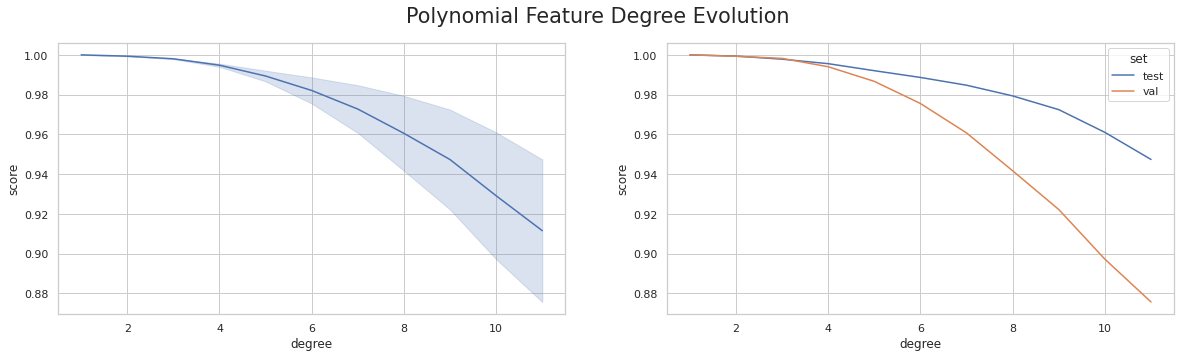

In [969]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Polynomial Feature Degree Evolution', fontsize='xx-large')
_ = sns.lineplot(
  data=df_degree_accuracy,
  x='degree',
  y='score',
  ax=axes[0]
)
_ = sns.lineplot(
  data=df_degree_accuracy,
  x='degree',
  y='score',
  hue='set',
  ax=axes[1]
)

### Polynomial Linear Regression

Polynomial Linear Regression is just Linear Regression but with some Polynomial features added to the equation, basically, we add complexity to the equation as to better understand and solve the problem.

In [695]:
def build_polynomial_linear_regr_model(
  degree: int = 1
) -> Pipeline:
  return make_pipeline(
    SELECTED_NORMALIZATION_SCALER(),
    PolynomialFeatures(degree=degree),
    LinearRegression(),
  )

As we saw on the plot, `1` degree should be the best choice, rather, the one with the higest score, but higher score doesn't necessarly mean better, as we may be overfitting our model (we, fore sure, are).

In [696]:
polynomial_linear_regr = build_polynomial_linear_regr_model()
polynomial_linear_regr.fit(X_train, y_train)

evaluate_model(polynomial_linear_regr, 'polynomial_linear_regr')

99.556%
99.401%


#### Regression

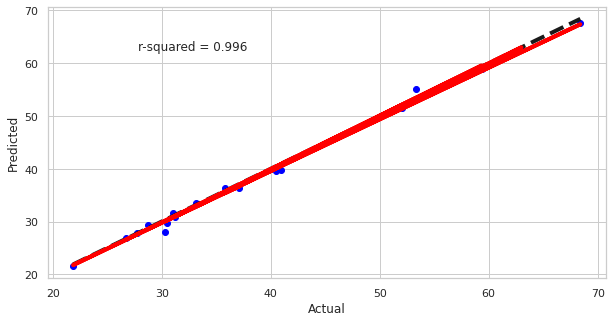

In [697]:
plot_regression(
  model=polynomial_linear_regr,
  base_model=build_polynomial_linear_regr_model,
  X_true=X_test,
  y_true=y_test,
  figsize=(10, 5)
)

### PCA Explainability

PCA, Principal Component Analysis, is a feature reduction technique to compress information so that our model computes much faster, but we compress that information in `n` components, to get the best number of components, we, once again, plot it.

In [698]:
pca_explainability = list()

for n_components in range(1, X_train.shape[1]):
  temp_pca_model = PCA(n_components)
  temp_pca_model.fit_transform(X_train, y_train)
  pca_explainability.append([
    n_components,
    temp_pca_model.explained_variance_ratio_.sum(),
  ])

In [699]:
df_pca_explainability = pd.DataFrame(
  pca_explainability,
  columns=[
    'n_components',
    'explainability',
  ]
)

As to select the best number of components, we'll use the elbow method.

We're looking for a ratio of the most amount of explainability in the less number of components as possible.

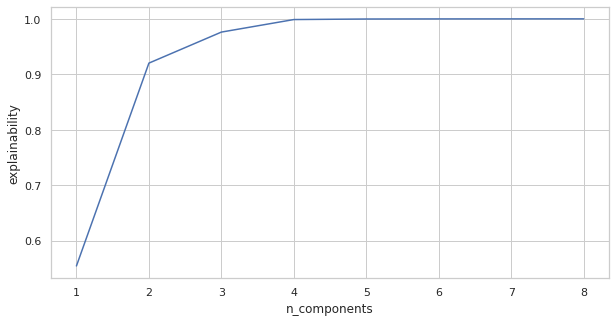

In [700]:
plt.figure(figsize=(10, 5))
_ = sns.lineplot(data=df_pca_explainability, x='n_components', y='explainability')

In [701]:
df_pca_explainability.head(5)

,n_components,explainability
0,1,0.554658
1,2,0.920225
2,3,0.976139
3,4,0.998730
4,5,0.999715


### Linear Regressiong using PCA

As aforementioned, the Linear Regression model stays the same, it will just compute with much less number of features while maintaining almost the same information

In [702]:
def build_linear_regr_pca_model(n_components=1) -> Pipeline:
  return make_pipeline(
    SELECTED_NORMALIZATION_SCALER(),
    PCA(n_components=n_components),
    LinearRegression(),
  )

In [703]:
linear_regr_pca = build_linear_regr_pca_model(n_components=4)
linear_regr_pca.fit(X_train, y_train)

evaluate_model(linear_regr_pca, 'linear_regr_pca')

92.181%
93.185%


#### Regression

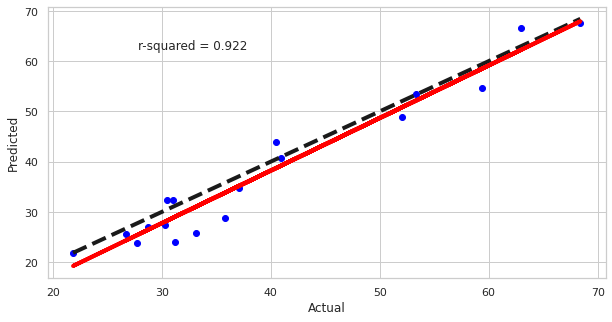

In [704]:
plot_regression(
  model=linear_regr_pca,
  base_model=build_linear_regr_pca_model,
  X_true=X_test,
  y_true=y_test,
  figsize=(10, 5)
)

### Support Vector Machine

Support Vector Machine Regressor solves the problem by, rather than tackling the problem at once, dividing it into smaller problems it can easily solve

In [705]:
def build_svr_model() -> Pipeline:
  return Pipeline(
    steps=[
      ['scaler', SELECTED_NORMALIZATION_SCALER()],
      ['regr', SVR(
        C=20.0,
        epsilon=1.0,
      )],
    ]
  )

In [706]:
svr_regr = build_svr_model()
svr_regr.fit(X_train, y_train)

evaluate_model(svr_regr, 'svr_regr')

97.348%
96.316%


#### Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


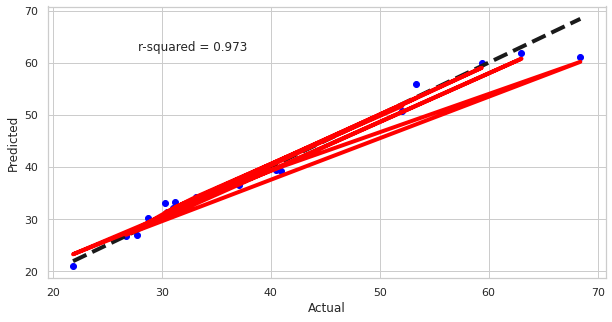

In [707]:
plot_regression(
  model=svr_regr,
  base_model=build_svr_model,
  X_true=X_test,
  y_true=y_test,
  figsize=(10, 5)
)

## Result comparison and double-checking

Explain

TODO: Create helper functions

### Test set comparison

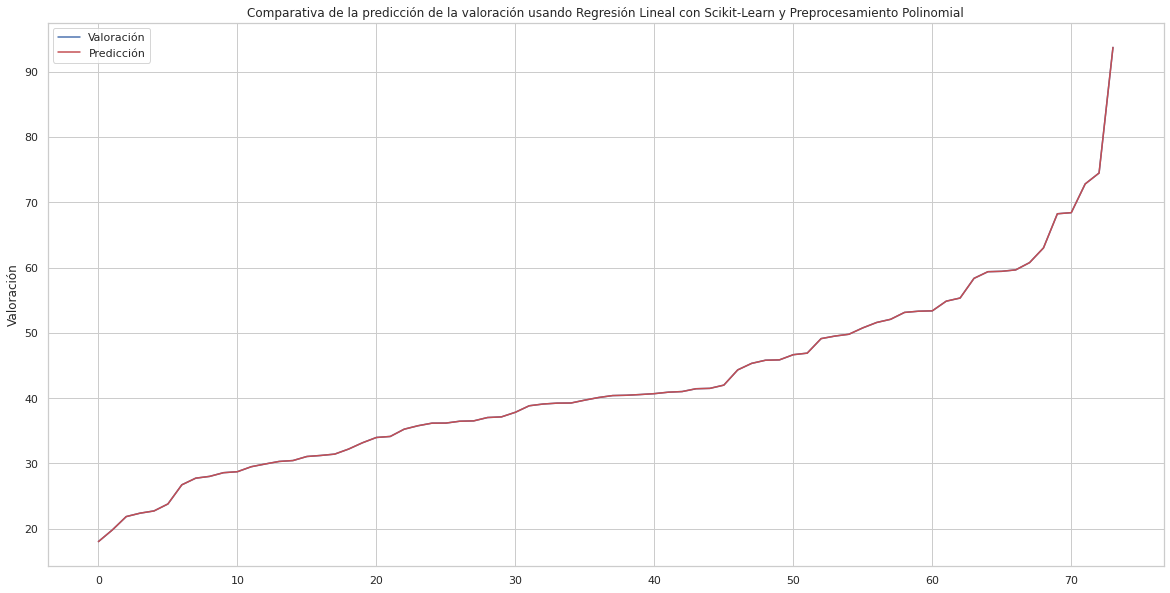

In [708]:
results = pd.DataFrame(
  zip(predictions_dict['total']['linear_regr'], y.values),
  columns=['prediction', 'rating']
).sort_values(
  by=['rating'],
  ignore_index=True
)
temp_df_lr = results.sort_values(by=['rating'], ignore_index=True)

plt.figure(figsize=(20,10))
plt.plot(temp_df_lr['rating'].index, temp_df_lr['rating'], color='b', label='Valoración')

plt.plot(temp_df_lr['prediction'].index, temp_df_lr['prediction'], color='r', label='Predicción')

plt.xlabel("")
plt.ylabel("Valoración")
plt.title("Comparativa de la predicción de la valoración usando Regresión Lineal con Scikit-Learn y Preprocesamiento Polinomial")
plt.legend()
plt.show()

Utility function to visually evaluate the performance of the models applied

In [709]:
def plot_set_of_data_predictions(
  set_of_data: str = 'total',
  figsize: Tuple[float, float] = (30, 20),
  line_width: float = 2.5
) -> None:
  global predictions_dict, y, TARGET_VARIABLE

  results = (
    pd.DataFrame(
      zip(
        y.values,
        *predictions_dict[set_of_data].values(),
      ),
      columns=[
        TARGET_VARIABLE,
        *predictions_dict[set_of_data].keys(),
      ]
    )
    .sort_values( by=[TARGET_VARIABLE], ignore_index=True )
  )

  temp_df_lr = results.copy(deep=True)

  plt.figure(figsize=(30, 20))
  sns.lineplot(data=temp_df_lr.drop(columns=[
    TARGET_VARIABLE
  ]), lw=line_width)

  plt.xlabel('Index')
  plt.ylabel('Rating')
  plt.title('Comparativa de la predicción de la valoración usando Regresión Lineal con Scikit-Learn y Preprocesamiento Polinomial')
  plt.legend()
  plt.show()

### Real values

Plotting all of the true shape the different data sets take. As to have a better point of reference in comparisons

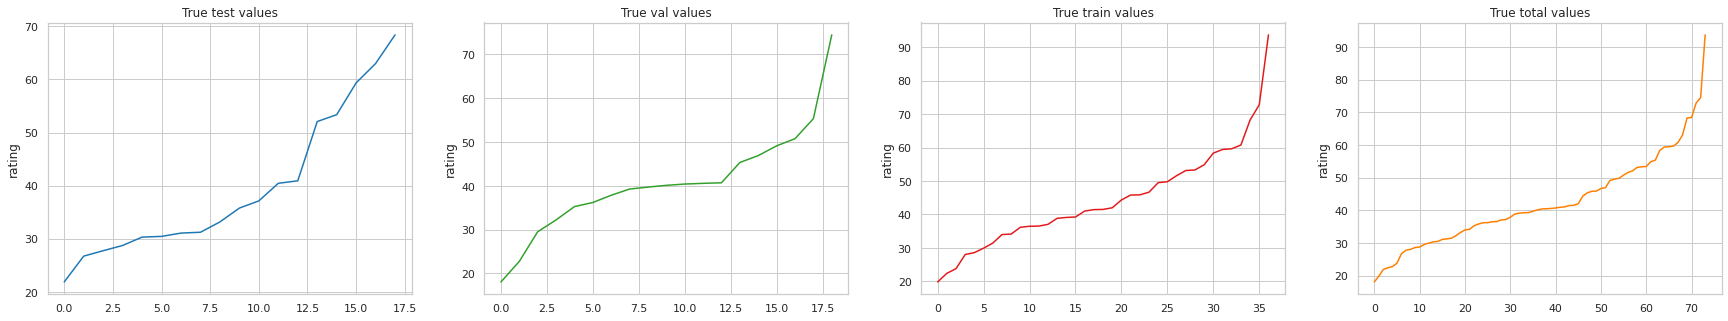

In [710]:
n_sets_of_data = len(sets_of_data.keys())

fig, axes = plt.subplots(1, n_sets_of_data, figsize=(n_sets_of_data * 7.5, 5))

for index, elements in enumerate(sets_of_data.items()):
  set_type, values = elements
  _, y_true = values

  df_set_of_data_y = (
    pd.DataFrame(
      y_true,
      columns=[TARGET_VARIABLE,]
    )
    .sort_values(
      by=TARGET_VARIABLE,
      ignore_index=True
    )
  )

  _ = sns.lineplot(
    data=df_set_of_data_y,
    x=df_set_of_data_y[TARGET_VARIABLE].index,
    y=TARGET_VARIABLE,
    ax=axes[index],
    color=sns.color_palette('Paired')[(index * 2) + 1],
  )
  axes[index].set_title(f'True {set_type} values')

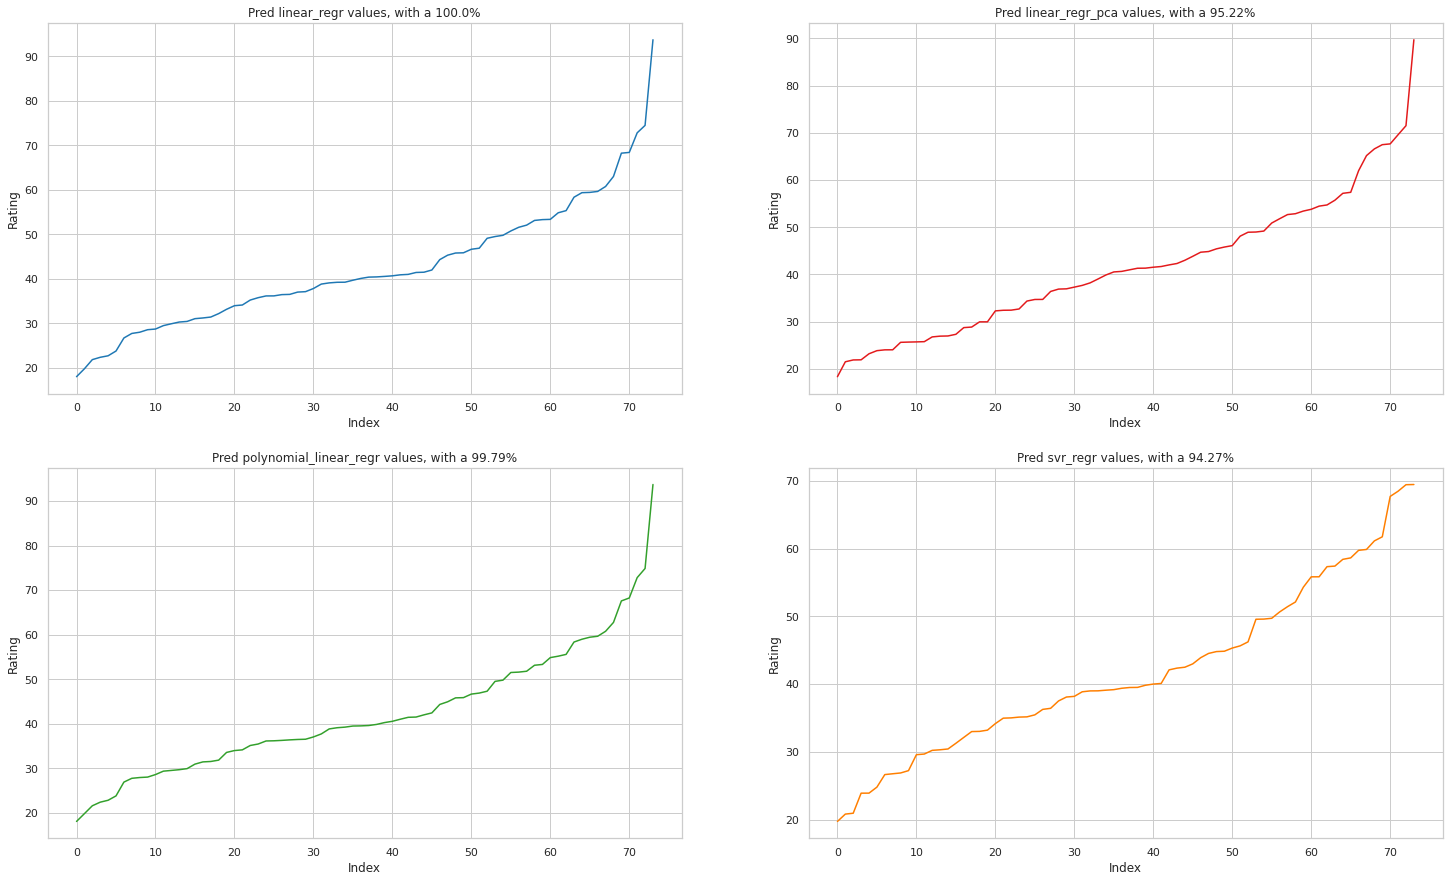

In [711]:
set_of_data_type = 'total'

working_set_of_data = predictions_dict[set_of_data_type]
n_working_set_of_data = len(working_set_of_data.keys())

n_cols = 2
n_rows = int(n_working_set_of_data / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 12.5, n_rows * 7.5))

for index, elements in enumerate(working_set_of_data.items()):
  algorithm_type, y_true = elements
  algorithm_score = performance_dict[set_of_data_type][algorithm_type]

  df_set_of_data_y = (
    pd.DataFrame(
      y_true,
      columns=[TARGET_VARIABLE,]
    )
    .sort_values(
      by=TARGET_VARIABLE,
      ignore_index=True
    )
  )

  ax = axes[
    int(index % n_cols),
    int(index / n_cols),
  ]

  _ = sns.lineplot(
    data=df_set_of_data_y,
    x=df_set_of_data_y[TARGET_VARIABLE].index,
    y=TARGET_VARIABLE,
    ax=ax,
    color=sns.color_palette('Paired')[(index * 2) + 1],
  )
  ax.set_xlabel('Index')
  ax.set_ylabel(TARGET_VARIABLE.title())
  ax.set_title(f'Pred {algorithm_type} values, with a {format_score(algorithm_score, 2)}%')

Overfitting

Evaluate the performance on all the dataset at once

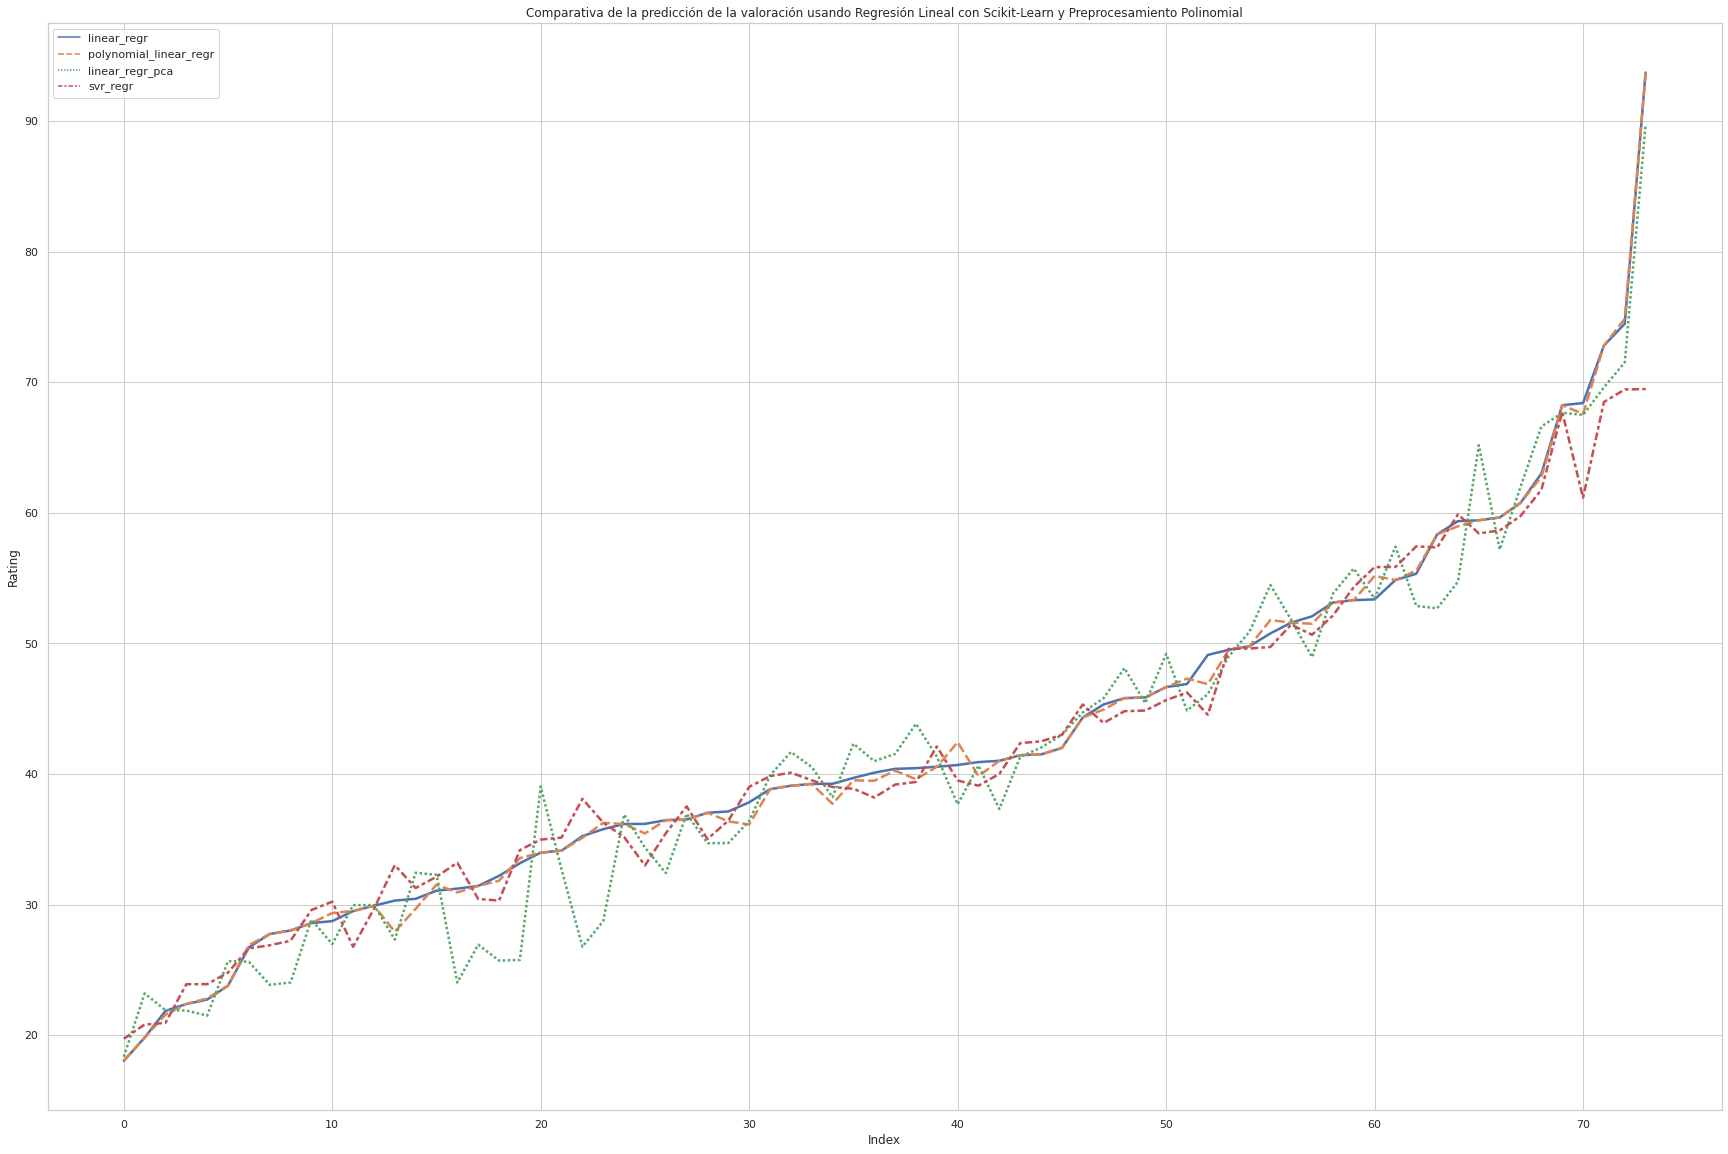

In [712]:
# TODO: implement subplots
plot_set_of_data_predictions(set_of_data='total')

## Conclusions

As to summarize the regression side of this project, just some notes.

### Cleaning the data

In larger datasets, losing a couple of rows is no big deal, with `77` rows, losing `5`?! It's risky, but necessary.

And just because there's barely any data (compared to larger projects) it's no excute not to evaluate any possible error. Or to do an extensive exploration (not that we did one, but we tried)

### Algorithms

Just because an algorithm is said to be simple, or classified as such, doesn't mean is not powerful, sometimes the simplest of things can solve the most compelx problems.

LinearRegression proved just that, with variations to it, obviously.

Support Vector Machine on the other hand, is an overkill for such a small project, it is meant for larger datasets, but it got some conclusions.

### Overfitting

As expected, we have some overfitting going on, which is more evident on the plain LinearRegression, but there wasn't much way around it to be honest

### Small Datasets

Small amounts of data can be deceiving, as we saw, the models performed with huge scores, almost perfect (one even got too mathematically close to 1.0).

And are also a _pain in the ass_ to work with, let's be honest. They're super sensible and prone to errors, one little mistake gets magnified. Which is why it was important to work this project to an end.

# Classification

Using the same dataset, we're going to tackle a different objective, well, same objective, sort of, but different technique.

It's either, five or three labels. But it would also be applied to the rating, and now we're talking about distribution, in a small dataset, huge problems ahead!

We could try and predict the manufacturer, but it wouldn't be a great idea, we're not building a descriptive model, we're trying to create a model that can predict the rating.

In [713]:
CLASSIFICATION_TARGET_VARIABLE = 'rating' #@param {type: 'string'}
N_CLASSIFICATION_LABELS = 3 #@param {type: 'integer'}

## Backup

First of all, no matter it's full scope, we backup the dataframe we're going to use. Just in case.

We'll rename it to `dfc` as in **D**ata **F**rame **C**lassification.

In [714]:
dfc = df.copy()

## Data Cleansening

This time around, the data is already clean, but we need to make some adjustments, we have one really high rating, way above the average, as an outlier for regression is great, having that in our classification problem, and only one example of it, it can be catastrophical

In [715]:
dfc[ dfc[CLASSIFICATION_TARGET_VARIABLE] >= 90.0 ]

,name,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
3,All-Bran with Extra Fiber,2,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.5,93.704912


We can simply remove it by excluding all those cereals above 90 and we'll reindex the DataFrame as to avoid any further problems down the line

In [716]:
dfc = dfc[ dfc[CLASSIFICATION_TARGET_VARIABLE] < 90.0 ].reindex()

So we can now have a rathing that's cleaner and more fit for classification

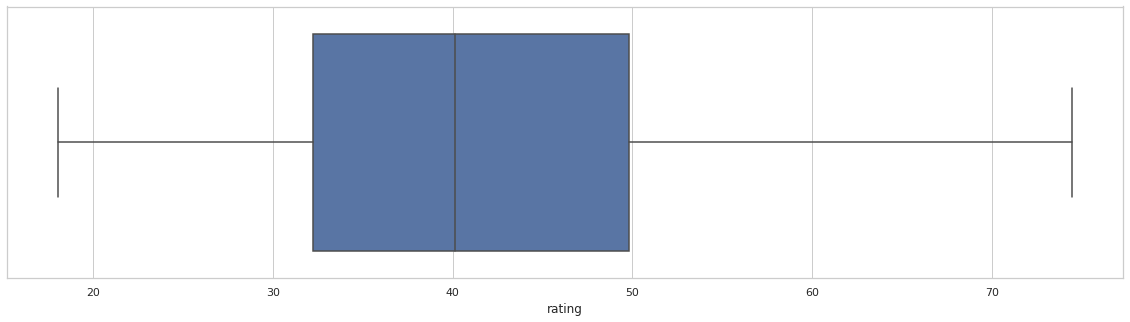

In [717]:
plt.figure(figsize=(20, 5))
_ = sns.boxplot(data=dfc, x=CLASSIFICATION_TARGET_VARIABLE)

## Data Preprocessing

We can now start creating what's left for our classification problem, the labels. We must transform our continue `rating` column into a categorical discrete column.

### Label conversion

We'll convert the column into a categorical column

In [718]:
dfc[CLASSIFICATION_TARGET_VARIABLE] = pd.cut(
  dfc[CLASSIFICATION_TARGET_VARIABLE],
  N_CLASSIFICATION_LABELS,
  retbins=True
)[0]

We can see how it's now a categorical column ready to be worked with

In [719]:
dfc[CLASSIFICATION_TARGET_VARIABLE].dtype

CategoricalDtype(categories=[(17.986, 36.853], (36.853, 55.663], (55.663, 74.473]], ordered=True)

And we factorize them as to have numeric values that we can more easily understand

In [720]:
# dfc[CLASSIFICATION_TARGET_VARIABLE] = pd.factorize(dfc[CLASSIFICATION_TARGET_VARIABLE])[0]

### Label distribution

Having a discrete column allows us to see it's distribution

In [721]:
classification_distribution = dfc[CLASSIFICATION_TARGET_VARIABLE].value_counts()
classification_distribution

(36.853, 55.663]    35
(17.986, 36.853]    28
(55.663, 74.473]    10
Name: rating, dtype: int64

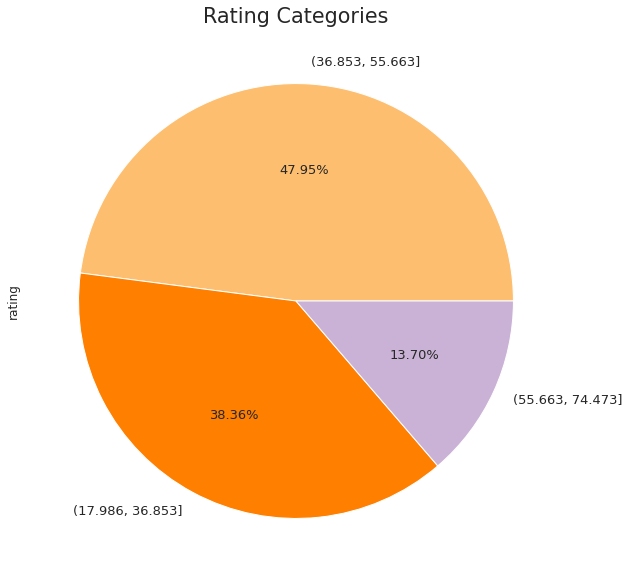

In [722]:
plt.figure(figsize=(10, 10))
plt.title(
  f'{CLASSIFICATION_TARGET_VARIABLE} categories'.title(),
  fontsize='xx-large'
)
_ = classification_distribution.plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired')[6:],
)

The reason three labels are better than five, is as simple as, having five would leave us with a huge imbalancement that'd be impossible to fix, so we'd end up having a biased model.

As to better avoid that problem, three labels seemed a better fit.

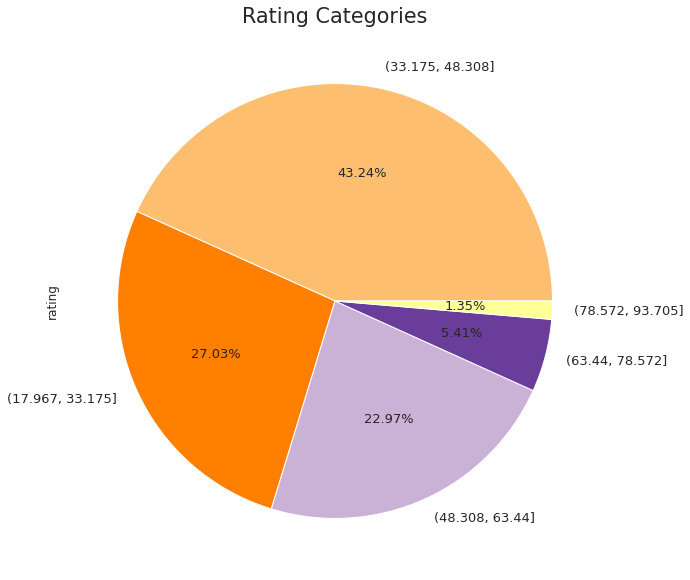

In [723]:
plt.figure(figsize=(10, 10))
plt.title(
  f'{CLASSIFICATION_TARGET_VARIABLE} categories'.title(),
  fontsize='xx-large'
)
_ = pd.DataFrame(
  pd.cut(
    df[CLASSIFICATION_TARGET_VARIABLE],
    5,
    retbins=True
  )[0],
  columns=['rating']
)['rating'].value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired')[6:],
)

## Data preparation

Let's, once again, identify our training and label columns, and split into train and test, this time around, no validation data

### Label dictionary

We've categorized our label values, yes we can read them, but they sure are harder to understand that if we were to give them some proper naming, which is exactly what we'll do.

In [724]:
ranged_label_dict = dict(zip(
  dfc[ CLASSIFICATION_TARGET_VARIABLE ].cat.codes.sort_values().unique(),
  dfc[ CLASSIFICATION_TARGET_VARIABLE ].cat.categories
))

In [725]:
named_label_dict = {
  0: 'Bad',
  # 0: 'Not Bad',
  # 1: 'Mediocre',
  1: 'Kinda good',
  # 2: 'Good',
  2: 'Good',
}

### Assignment

We'll do exactly as before, repeating the same steps but with some new varaible naming

In [726]:
classification_ignore_cols = [
  CLASSIFICATION_TARGET_VARIABLE,
  'name',
  # once again, it barely has any coefficient at all
  'mfr',
]
classification_training_cols = [ col for col in dfc.columns if col not in classification_ignore_cols ]

Once we've identified the columns, we select them

In [727]:
X_classification = dfc[ classification_training_cols ]
y_classification = dfc[ CLASSIFICATION_TARGET_VARIABLE ].cat.codes

### Training set Distribution

We'll do the splitting after the data balancement, that's a key difference between regression.

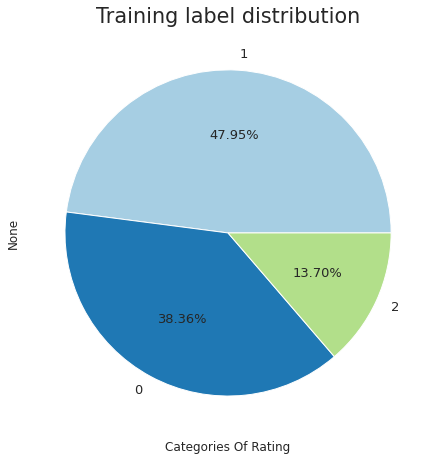

In [728]:
plt.figure(figsize=(7.5, 7.5))
plt.title('Training label distribution', fontsize='xx-large')
plt.xlabel(f'Categories of {CLASSIFICATION_TARGET_VARIABLE}'.title())
_ = y_classification.value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired'),
)

## Data Imbalancement

It's a given that in a classification there's going to be some sort of imbalancement, but, having a small dataset, it was bound to have a bigger imbalancement

In [730]:
len(y_classification)

73

In [731]:
from imblearn.under_sampling import RandomUnderSampler

def build_undersampler() -> RandomUnderSampler:
  return RandomUnderSampler(
    random_state=RANDOM_SEED,
  )

In [732]:
X_classification, y_classification = build_undersampler().fit_resample(X_classification, y_classification)

In [733]:
len(y_classification)

30

And we can now see a more even distribution on the label

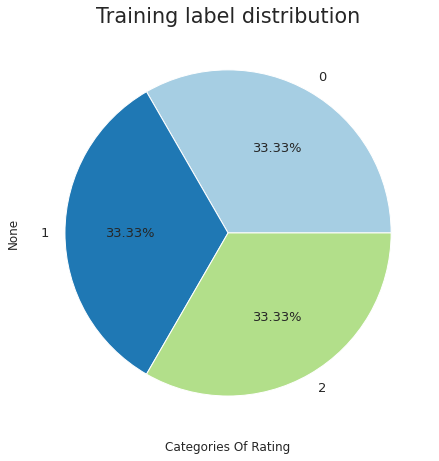

In [734]:
plt.figure(figsize=(7.5, 7.5))
plt.title('Training label distribution', fontsize='xx-large')
plt.xlabel(f'Categories of {CLASSIFICATION_TARGET_VARIABLE}'.title())
_ = y_classification.value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired')
)

### Data Splitting

We'll have to work with an eve smaller dataset, but at least it'll be balanced. It's always better to work with less but richer than more but dirtier.

```
QUALITY > QUANTITY
```

Let's get hands on

In [735]:
X_classification_train, X_classification_test, y_classification_train, y_classification_test = train_test_split(
  X_classification, y_classification, test_size=.4, random_state=RANDOM_SEED, stratify=y_classification
)

We can, once again, check out the distribution of our training set

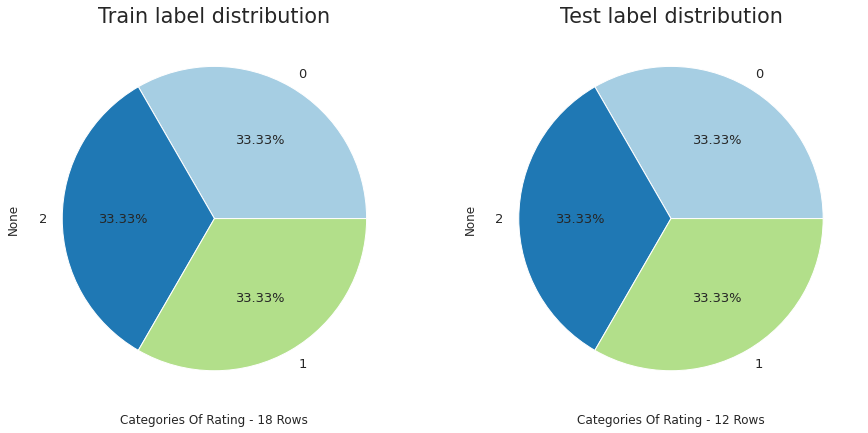

In [736]:
fig, axes = plt.subplots(1, 2, figsize=(7.5 * 2, 7.5))

# Train set distribution
axes[0].set_title('Train label distribution', fontsize='xx-large')
axes[0].set_xlabel(f'Categories of {CLASSIFICATION_TARGET_VARIABLE} - {len(y_classification_train)} rows'.title())
_ = y_classification_train.value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired'),
  ax=axes[0],
)

# Test set distribution
axes[1].set_title('Test label distribution', fontsize='xx-large')
axes[1].set_xlabel(f'Categories of {CLASSIFICATION_TARGET_VARIABLE} - {len(y_classification_test)} rows'.title())
_ = y_classification_test.value_counts().plot.pie(
  autopct='%1.2f%%',
  fontsize=13,
  colors=sns.color_palette('Paired'),
  ax=axes[1],
)

They're even, and the data is evenly splitted as well.

## Data Science

Let's now work on our algorithms, modelling in classification feels like more tedious to me, it's as if there was less room for freedom, since it needs to fall under `n` labels, no mistaking there.

No room for exploration I feel

### Imports

In [737]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

### Helpers

#### Confussion Matrix

Confussion matrix attempts to find the amount of times, when classifying, we got it right, and we didn't, per class.

We're working with a multilabel classification problem, so it'll be a multicolumn matrix

A helper function to visualize the confusion matrix

In [738]:
def cmatrix(
  y_true: pd.DataFrame,
  y_pred: pd.DataFrame,
  target_names: List[str] = named_label_dict.values()
) -> None:
  df_cm = confusion_matrix(y_true, y_pred)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  plt.figure(figsize=(20, 15))
  sns.heatmap(
    df_cm,
    square=True,
    annot=True,
    # fmt='.2g',
    annot_kws={ 'fontsize': 13 },
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='Blues',
    cbar=True,
    cbar_kws={'orientation': 'horizontal'},
  )

#### Classification Report



In [739]:
def creport(
  y_true: pd.DataFrame,
  y_pred: pd.DataFrame,
  target_names: List[str] = named_label_dict.values()
) -> None:
  report = classification_report(
    y_true,
    y_pred,
    target_names=target_names
  )

  print(report)

#### ROC AUC Curve

Straight from: https://www.sciencedirect.com/science/article/pii/S1556086415306043

AUC can be computed using the trapezoidal rule. In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

Code from: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification#answer-59326862

In [740]:
def plot_roc_auc_curve(
  y_score: np.ndarray,
  y_true: np.ndarray = y_classification_test,
  figsize: Tuple[float, float] = (25, 10),
  target_names_dict: dict = named_label_dict,
  n_labels: int = N_CLASSIFICATION_LABELS,
) -> None:
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
  for label_index in range(n_labels):
      fpr[label_index], tpr[label_index], _ = roc_curve(y_test_dummies[:, label_index], y_score[:, label_index])
      roc_auc[label_index] = auc(fpr[label_index], tpr[label_index])

  # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])

  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')

  for classification_index in range(n_labels):
    classification_label_str = 'ROC curve (area = %0.2f) for label %s' % (
      roc_auc[classification_index],
      target_names_dict[classification_index]
    )
    ax.plot(
      fpr[classification_index],
      tpr[classification_index],
      label=classification_label_str,
      lw=2,
    )

  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

### Logistic Regression

It's Linear Regression but with a Logarithmic function applied to it's outcome and uses decission boundary (a number from which it's one thing or the other) to classify.

As we're working with multiclass classification, that means that our model we'll, under the hood, use a technique called *one vs all*, which is to create a classifier per label to predict, and later compare them, the one with the higher probability, is the one that gets chosen as the prediction.

In [741]:
from sklearn.linear_model import LogisticRegression

def build_logistic_regr_clf_model() -> Pipeline:
  return Pipeline(
    steps=[
      ['scaler', SELECTED_NORMALIZATION_SCALER()],
      ['clf', LogisticRegression()],
    ]
  )

In [742]:
logistic_regr_clf = build_logistic_regr_clf_model()
logistic_regr_clf.fit(X_classification_train, y_classification_train)

y_pred_logistic_regr_clf = logistic_regr_clf.predict(X_classification_test)
decision_logistic_regr_clf = logistic_regr_clf.decision_function(X_classification_test)

logistic_regr_clf_score = logistic_regr_clf.score(X_classification_test, y_classification_test)
display_score(logistic_regr_clf_score, 2)

66.67%


#### Explainability

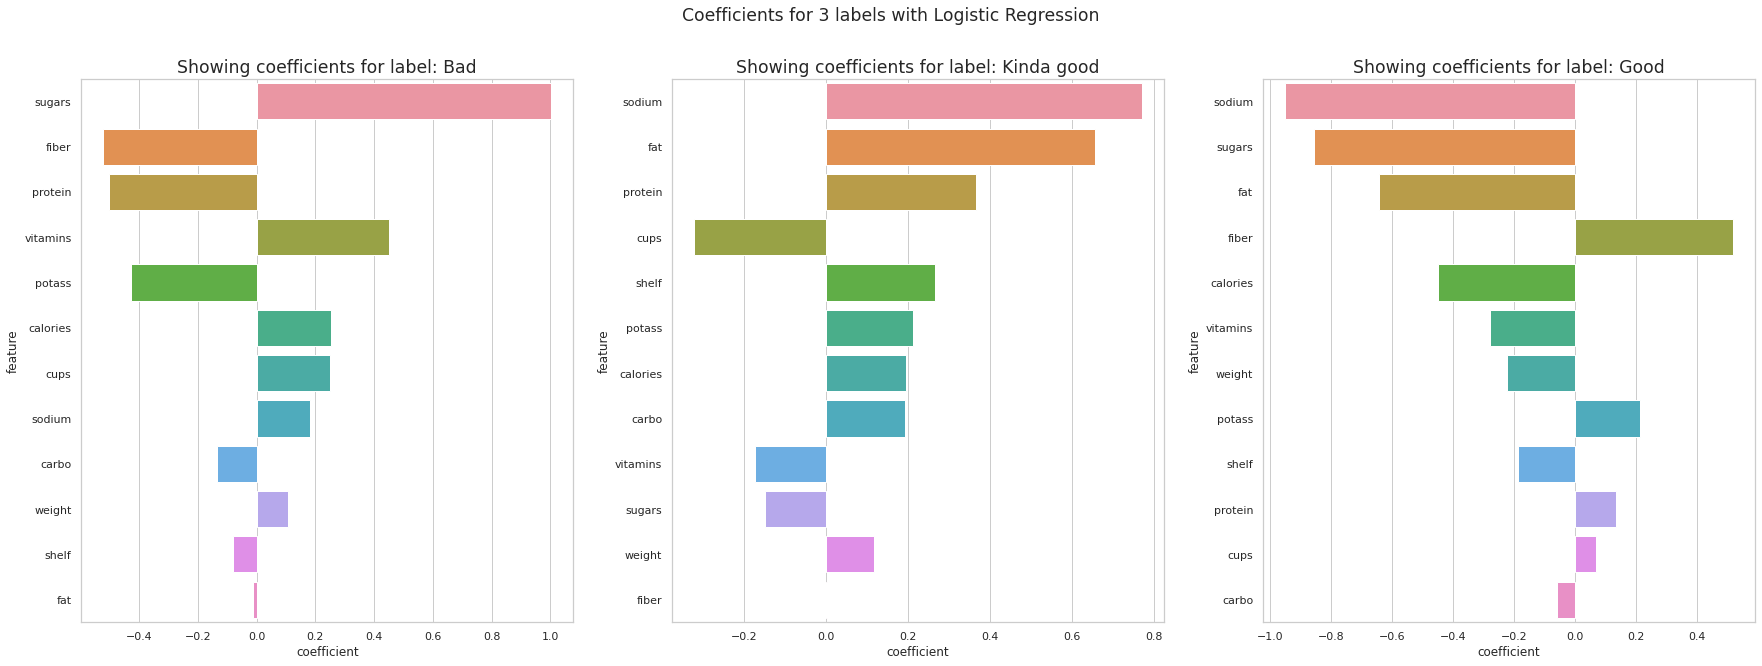

In [743]:
n_classification_features = len(X_classification_train.columns)

# TODO: hacer que see computen todo de una en un macro bloque de código que ya refactorizaré más tarde
# si eso

# TODO: añadir polynomial features

fig, axes = plt.subplots(1, N_CLASSIFICATION_LABELS, figsize=(30, 10))
fig.suptitle(
  f'Coefficients for {N_CLASSIFICATION_LABELS} labels with Logistic Regression',
  fontsize='x-large'
)

for label_index, ax in enumerate(axes):
  df_logistic_regr_clf_explainability = pd.DataFrame(
    zip(
      X_classification_train.columns,
      logistic_regr_clf['clf'].coef_[label_index],
    ),
    columns=['feature', 'coefficient']
  )

  df_logistic_regr_clf_explainability['abs_coef'] = df_logistic_regr_clf_explainability['coefficient'].abs()

  ax.set_title(f'Showing coefficients for label: {named_label_dict[label_index]}', fontsize='x-large')
  _ = sns.barplot(
    data=(
      df_logistic_regr_clf_explainability
      .sort_values(by='abs_coef', ascending=False)
    ),
    x='coefficient',
    y='feature',
    ax=ax
  )

#### Confusion Matrix

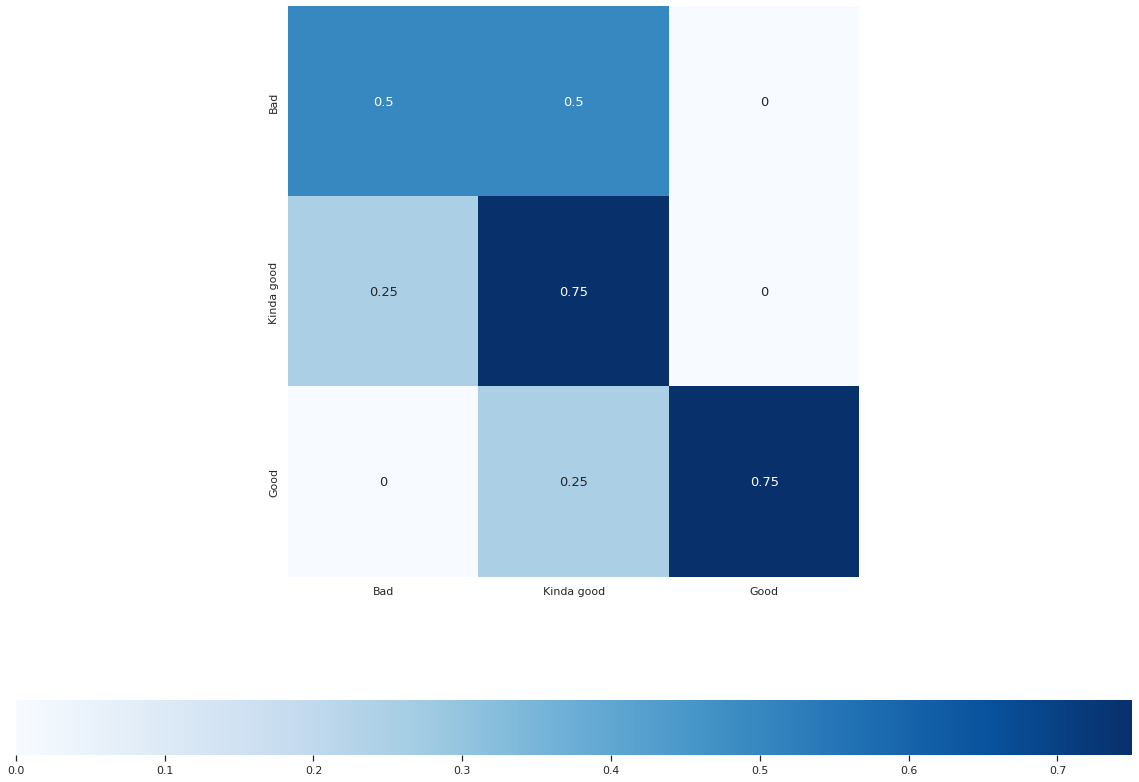

In [744]:
cmatrix(
  y_classification_test,
  y_pred_logistic_regr_clf,
)

#### Classification report

In [745]:
creport(
  y_classification_test,
  y_pred_logistic_regr_clf,
)

              precision    recall  f1-score   support

         Bad       0.67      0.50      0.57         4
  Kinda good       0.50      0.75      0.60         4
        Good       1.00      0.75      0.86         4

    accuracy                           0.67        12
   macro avg       0.72      0.67      0.68        12
weighted avg       0.72      0.67      0.68        12



#### ROC curve

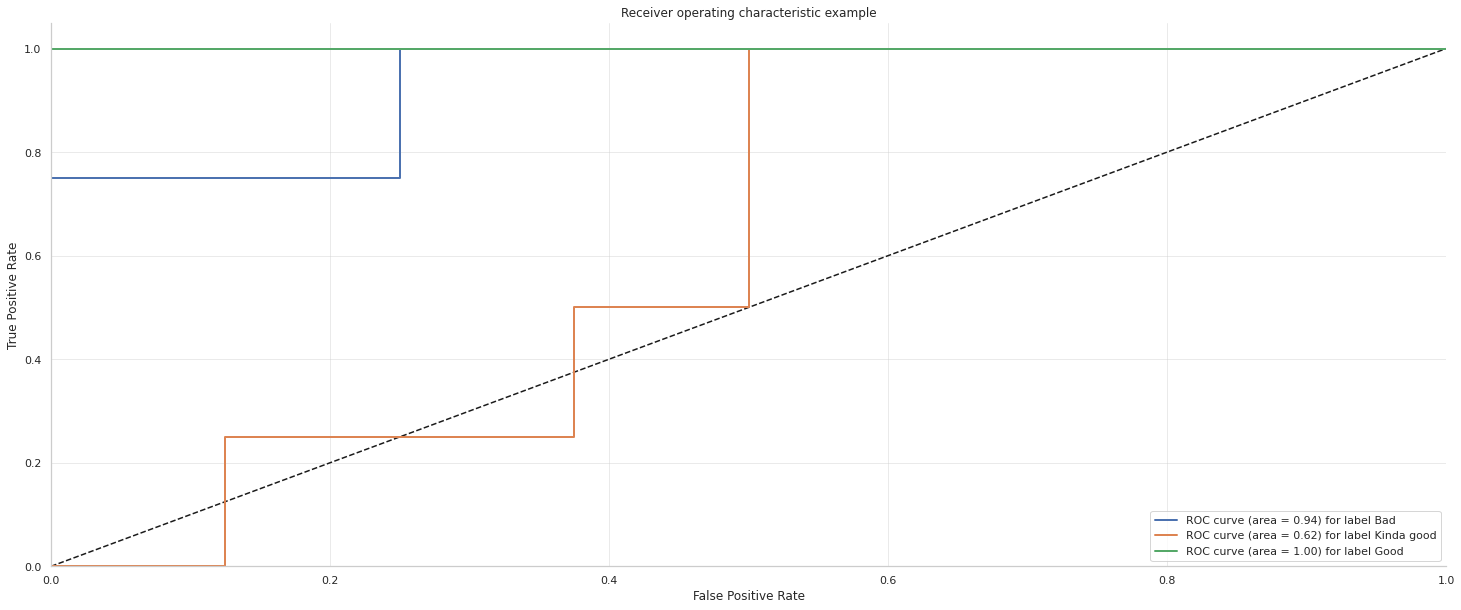

In [746]:
plot_roc_auc_curve(
  y_score=decision_logistic_regr_clf
)

### Polynomial Logistic Regression

PCA is used here to speed up the computing process, we're now working with thousands, the more we can compress that information, the faster our model will compute

In [771]:
from sklearn.linear_model import LogisticRegression

def build_polynomial_logistic_regr_clf_model(
  degree: int = 1,
  n_components: int = 2
) -> Pipeline:
  return Pipeline(
    steps=[
      ('scaler', SELECTED_NORMALIZATION_SCALER()),
      ('poly', PolynomialFeatures(degree=degree)),
      ('pca', PCA(n_components=n_components)),
      ('clf', LogisticRegression()),
    ]
  )

In [772]:
polynomial_logistic_regr_clf = build_polynomial_logistic_regr_clf_model(
  # degree=5,
  degree=9,
  # degree=2,
  n_components=15
)
polynomial_logistic_regr_clf.fit(X_classification_train, y_classification_train)

y_pred_polynomial_logistic_regr_clf = polynomial_logistic_regr_clf.predict(X_classification_test)
decision_polynomial_logistic_regr_clf = polynomial_logistic_regr_clf.decision_function(X_classification_test)

polynomial_logistic_regr_clf_score = polynomial_logistic_regr_clf.score(X_classification_test, y_classification_test)
display_score(polynomial_logistic_regr_clf_score, 2)

83.33%


#### Best degrees

As with Linear regression, we can check which degree fits best our model, it's kind of heavy on the computing, and we're able to do this given that we have a Dataset with not many features and too few samples.

Otherwise this would be crazy!!

In [749]:
clf_degree_accuracy = list()

for degree in range(1, 12):
  temp_polynomial_logistic_regr_clf = build_polynomial_logistic_regr_clf_model(
    degree=degree
  )
  temp_polynomial_logistic_regr_clf.fit(X_classification_train, y_classification_train)
  clf_degree_accuracy.append([
    degree,
    temp_polynomial_logistic_regr_clf.score(X_classification_test, y_classification_test),
  ])
  print(f'Just evaluated the {degree}th degree')

In [750]:
df_clf_degree_accuracy = pd.DataFrame(
  clf_degree_accuracy,
  columns=['degree', 'score']
)

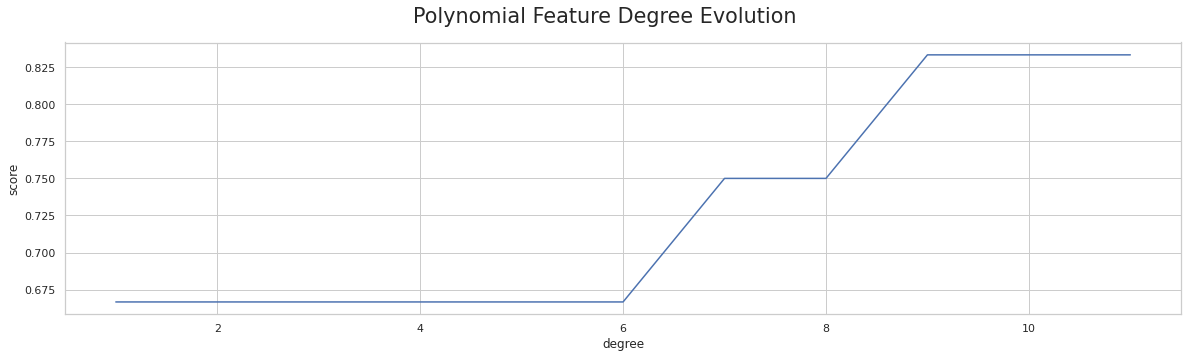

In [751]:
plt.figure(figsize=(20, 5))
plt.suptitle('Polynomial Feature Degree Evolution', fontsize='xx-large')
_ = sns.lineplot(
  data=df_clf_degree_accuracy,
  x='degree',
  y='score',
)

#### Confusion Matrix

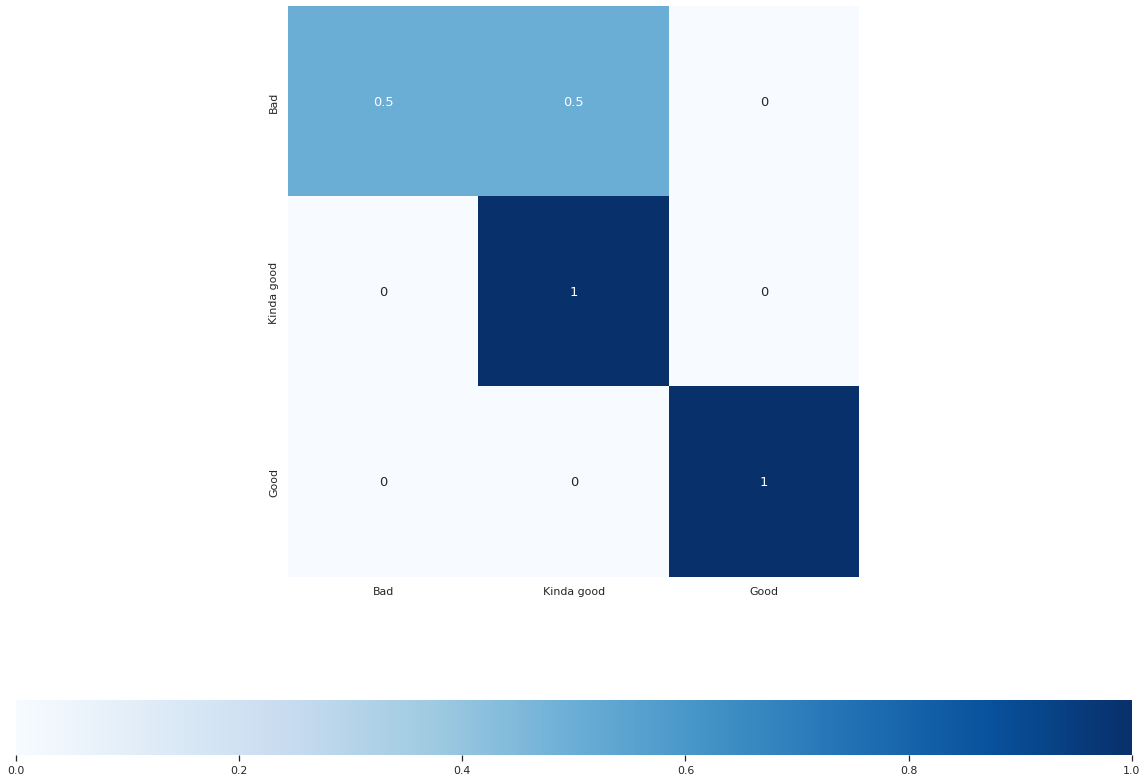

In [758]:
cmatrix(
  y_classification_test,
  y_pred_polynomial_logistic_regr_clf,
)

#### Classification report

In [759]:
creport(
  y_classification_test,
  y_pred_polynomial_logistic_regr_clf,
)

              precision    recall  f1-score   support

         Bad       1.00      0.50      0.67         4
  Kinda good       0.67      1.00      0.80         4
        Good       1.00      1.00      1.00         4

    accuracy                           0.83        12
   macro avg       0.89      0.83      0.82        12
weighted avg       0.89      0.83      0.82        12



#### ROC curve

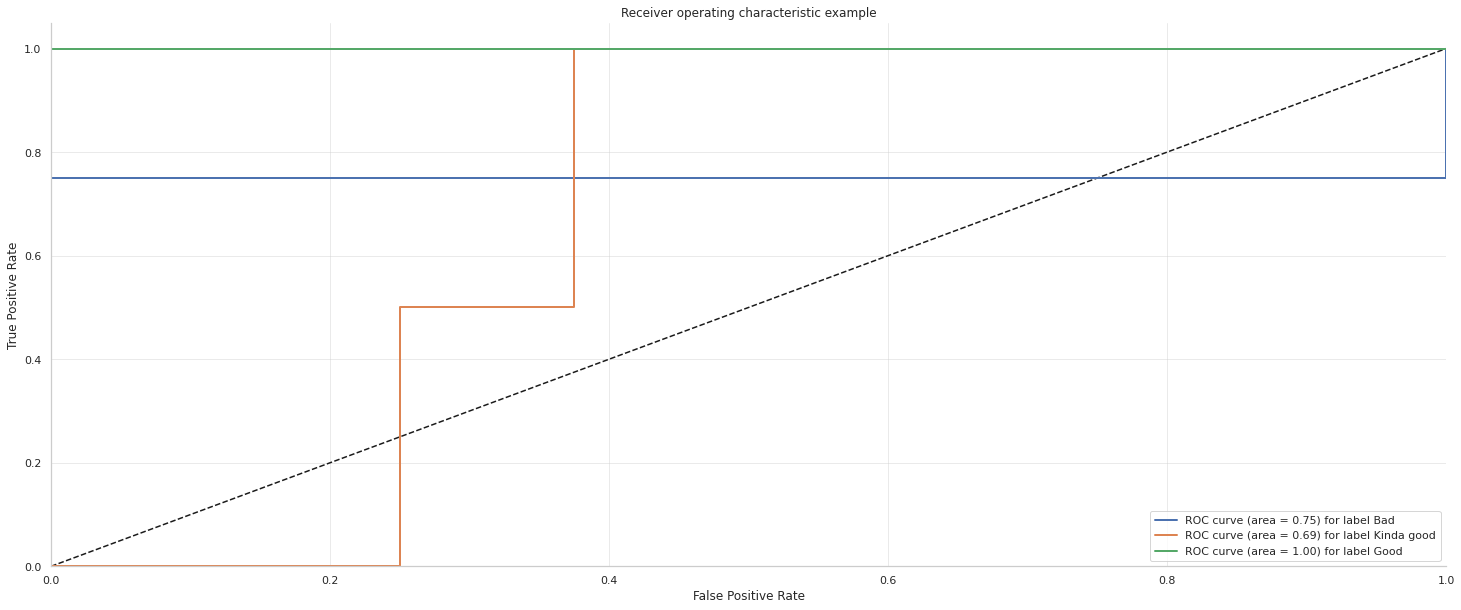

In [768]:
plot_roc_auc_curve(
  y_score=decision_polynomial_logistic_regr_clf
)

## Conclusions

Avoiding repeating myself with the aforementioned conclusions for regression, this is the recapitulation for the classification side of this project

### Multilabel classification

Classification by itself is a challenge, not only you have to make a prediction, it musn't be one of two options.

That risk only gets amplified in a multilabel project. But, classification is usually easier to have higher performance in. Since we're either guessing it right, or not. There's no in-between as there is with Regression.

A matter of preferences and differences. But working with multiclassification it's something closer to the real world, not to say that binary classification is not used, it is, and widely, but multiclass is too.

### Data Balancement

For our rating classification the data was imbalanced, which turned, our already small dataset, into an even smaller one, and the overfitting and testing problems that come with it.

We could fix it by undersampling the values, as to creating new values, randomzied, by oversampling, doesn't seem neither much reliable, nor trust-worthy.

### Algorithms

Not using PCA (directly) nor SVC this time around since it's important to have a clear explenation, just using polynomial to try things out, but also does not fit with the objective of this classification.

Polynomial here performed better, and PCA was used as to speed up the process, since we're actually computing a ton of features at once.

And a simple and steady horse wins the race. We won't have better conclusions with this much amount of data, but we can try to use the best techniques and the state-of-the-art.